## Import libraries

In [ ]:
!pip install torchmetrics -q # Metric compatible with PyTorch
!pip install visualimiss -q # For visualizing missing data, faster than missingno
!pip install torchinfo -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 14.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.utils.validation import check_random_state

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.nn import MSELoss
from torchmetrics import R2Score

In [ ]:
# Set print format
np.set_printoptions(
    precision=4,
    suppress=True
)

# Matplotlib settings
dpi = 200
plt.rcParams['figure.dpi'] = dpi
plt.rcParams['savefig.dpi'] = dpi

# seed for reproducibility
seed = 0
torch.manual_seed(seed)  # Seed for PyTorch on CPU

## Utils

### Timing decorator

In [ ]:
from time import perf_counter
from collections.abc import Callable
from functools import wraps

def timing(func: Callable):
    """Output time taken of function"""

    @wraps(func)
    def wrapper(*args, **kwargs):
        tic = perf_counter()
        result = func(*args, **kwargs)
        duration = np.format_float_positional((perf_counter() - tic)/60, precision=4)
        print(f' - {func.__name__}() took {duration} mins to run')
        return result

    return wrapper

### Generate dataset

In [ ]:
from math import sqrt
from torch.utils.data import TensorDataset
import visualimiss

def convert_to_tensor_dataset(X: np.ndarray, y: np.ndarray):
    return TensorDataset(
        torch.tensor(X, dtype=torch.float),
        torch.tensor(y, dtype=torch.float)
    )

def generate_dataset(
        n : int = 10000,
        d : int = 10,
        seed : int = 0,
        missing_rate : float = 0.5,
        verbose: int = 1,
    ):
    """Generate synthesis dataset"""
    # Set random seed for reproducible
    rng = check_random_state(seed)

    # Parameters of Gaussian data
    B = rng.randn(d, d//2)
    cov = B.dot(B.T) + np.diag(rng.uniform(low=0.01, high=0.1, size=d))

    mean = rng.randn(d)

    # Generate Gaussian data
    X = rng.multivariate_normal(mean=mean, cov=cov, size=n, check_valid='raise')

    # Generate y
    beta = np.repeat(1., d + 1)
    var = beta[1:].dot(cov).dot(beta[1:])
    beta[1:] *= 1/sqrt(var)
    y = X.dot(beta[1:]) + beta[0]

    snr = 10
    noise = rng.normal(loc=0, scale=sqrt(np.var(y)/snr), size=n)
    y += noise

    # Add missing values, MCAR
    missing_rate = 0.5
    ber = rng.rand(n, d)
    mask = ber < missing_rate
    np.putmask(X, mask, np.nan)

    # Visualize missing pattern of dataset
    if verbose:
        visualimiss.matrix(pd.DataFrame(X), figsize=(10, 6), show_label=False)
        plt.title(f'Missing pattern of dataset with {n} samples, {d} features, {missing_rate*100:.2f}% missing rate')
        plt.show()

    # train/val/test split
    n_train = int(0.8*n)
    n_val = int(0.1*n)
    val_end = n_train + n_val
    X_train, X_val, X_test = X[:n_train], X[n_train:val_end], X[val_end:]
    y_train, y_val, y_test = y[:n_train], y[n_train:val_end], y[val_end:]

    # Convert to PyTorch TensorDataset
    ds_train = convert_to_tensor_dataset(X_train, y_train)
    ds_val = convert_to_tensor_dataset(X_val, y_val)
    ds_test = convert_to_tensor_dataset(X_test, y_test)
    return ds_train, ds_val, ds_test

### Early Stopping

In [ ]:
from copy import deepcopy
# Early stopping: https://github.com/Bjarten/early-stopping-pytorch, slightly modified
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience: int = 7, verbose: bool = False, delta: float = 0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta

    def __call__(self, val_loss, model):
        # Check if validation loss is nan
        if np.isnan(val_loss):
            print("Validation loss is NaN. Ignoring this epoch.")
            return

        if self.best_val_loss is None:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_val_loss - self.delta:
            # Significant improvement detected
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0  # Reset counter since improvement occurred
        else:
            # No significant improvement
            self.counter += 1
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f})')

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        # if self.verbose:
            # print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), self.path)
        self.checkpoint = deepcopy(model.state_dict())
        self.val_loss_min = val_loss

## NeuMiss network

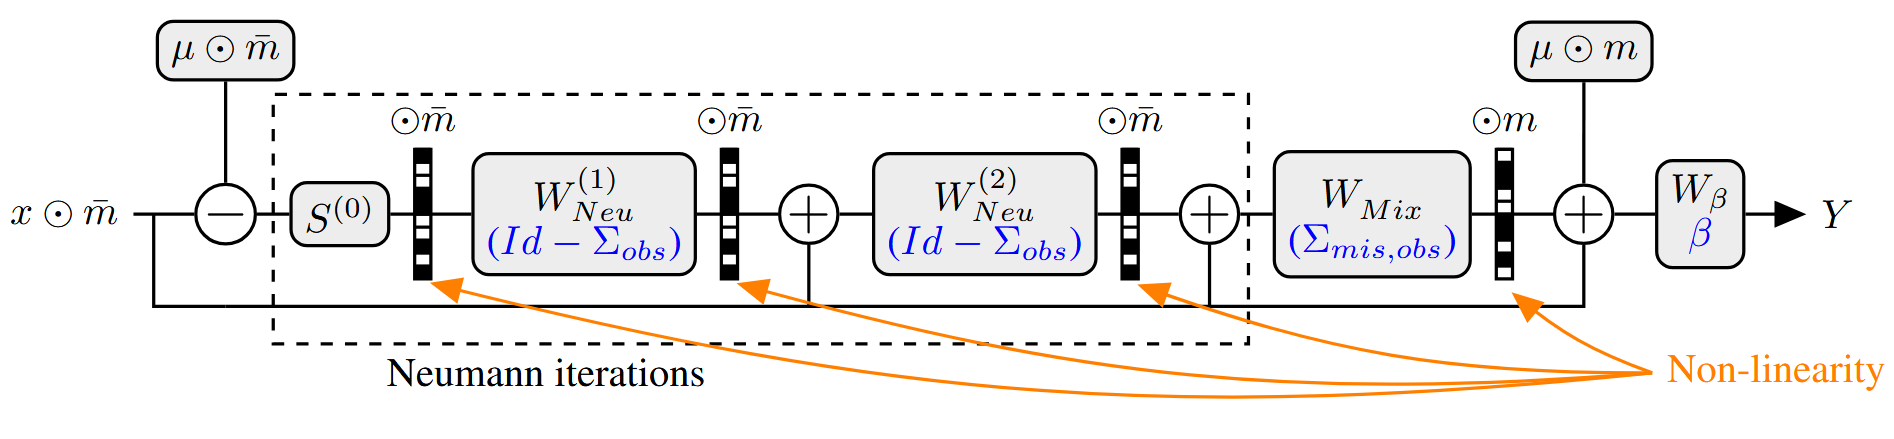

In [ ]:
class NeuMiss(nn.Module):
    """The NeuMiss network"""

    def __init__(
            self,
            n_features: int,
            depth: int,
            residual_connection: bool,
        ):
        super().__init__()
        # Neumann iteration depths
        self.depth = depth
        # Specify network data type
        self.dtype = torch.float
        # \mu is fixed vector in Bayes predictor -> use nn.Parameter instead of nn.Linear
        self.mu = nn.Parameter(torch.empty(n_features, dtype=self.dtype))
        # Specify residual connection in the network
        self.residual_connection = residual_connection
        # Weight matrix (W_{Neu}) for each layer depth
        self.l_W = nn.ModuleList([
            nn.Linear(n_features, n_features, bias=False, dtype=self.dtype)
            for _ in range(self.depth)
        ])
        # Weight matrix present \cov_{mis,obs}
        self.W_mix = nn.Linear(n_features, n_features, bias=False, dtype=self.dtype)
        # \beta in Bayes predictor
        self.beta = nn.Parameter(torch.empty(n_features, dtype=self.dtype))
        # Initialize parameters
        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.normal_(self.mu)
        for W in self.l_W:
            nn.init.xavier_normal_(W.weight)
        nn.init.xavier_normal_(self.W_mix.weight)
        nn.init.normal_(self.beta)

    def forward(self, x):
        """
        Parameters:
        ----------
        x: tensor, shape (batch_size, n_features)
            The input data, with missing values.
        """
        m = torch.isnan(x)  # mask
        x = torch.nan_to_num(x)  # impute missing data by 0
        # x now equal to x \odot \bar{m}
        h0 = x + m * self.mu   # equal to x \odot \bar{m} + \mu \odot m
        h = x - (~m) * self.mu   # (x - \mu) \odot \bar{m}
        h_residual = x - (~m) * self.mu  # residual connection

        for i, W in enumerate(self.l_W):
            h = W(h) * (~m)  # Apply each Linear layer
            if self.residual_connection and i > 0:  # not add residual connection after S^(0)
                h += h_residual

        h = self.W_mix(h) * m + h0
        y = torch.matmul(h, self.beta)
        return y

## Define Hyperparameters


In [ ]:
# batch_size = 64
batch_size = 256
criterion = nn.MSELoss()
learning_rate = 0.001
# epochs = 100

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Synthesis dataset

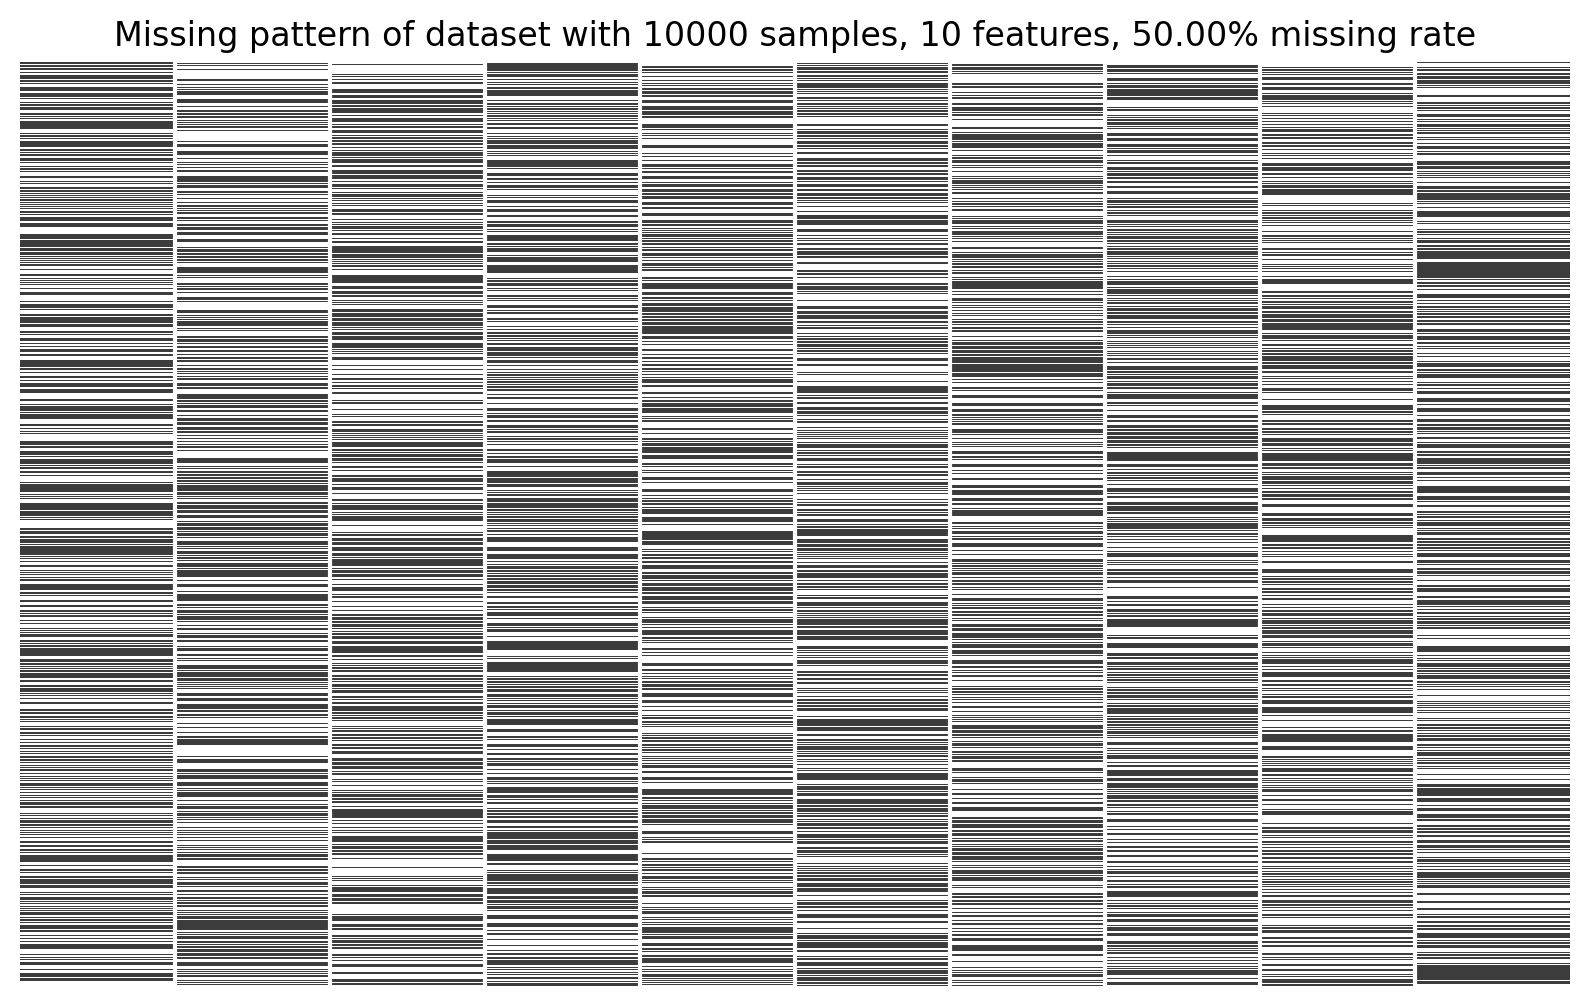

In [ ]:
# Dataset with 10000 samples, 10 features and has missing rate 50% (MCAR)
n = 10000
d = 10
ds_train, ds_val, ds_test = generate_dataset(n=n, d=d, missing_rate=0.5)
d = ds_train.tensors[0].shape[1]  # n_features

train_loader = DataLoader(ds_train, batch_size, shuffle=True)
val_loader = DataLoader(ds_val, batch_size)
test_loader = DataLoader(ds_test, batch_size)

### Training utils

#### Calculate Bayes rate

In [ ]:
from sklearn.metrics import r2_score

# Bayes rate estimated from Bayes predictor
rng = check_random_state(0)
B = rng.randn(d, d//2)
sigma = B.dot(B.T) + np.diag(rng.uniform(low=0.01, high=0.1, size=d))
mu = rng.randn(d)

# Generate Gaussian data
X = rng.multivariate_normal(mean=mu, cov=sigma, size=n, check_valid='raise')

# Generate y
beta = np.repeat(1., d + 1)
var = beta[1:].dot(sigma).dot(beta[1:])
beta[1:] *= 1/sqrt(var)
y = X.dot(beta[1:]) + beta[0]

snr = 10
noise = rng.normal(loc=0, scale=sqrt(np.var(y)/snr), size=n)
y += noise

# Add missing values, MCAR
missing_rate = 0.5
ber = rng.rand(n, d)
mask = ber < missing_rate
np.putmask(X, mask, np.nan)

# train/val/test split
n_train = int(0.8*n)
n_val = int(0.1*n)
val_end = n_train + n_val
X_train, X_val, X_test = X[:n_train], X[n_train:val_end], X[val_end:]
y_train, y_val, y_test = y[:n_train], y[n_train:val_end], y[val_end:]

# https://github.com/marineLM/NeuMiss/blob/master/python/ground_truth.py#L295
def bayes_predictor(X) -> np.ndarray:
    """Theoretical Bayes predictor from https://github.com/marineLM/NeuMiss"""
    pred = []
    for x in X:
        m = ''.join([str(mj) for mj in np.isnan(x).astype(int)])

        obs = np.where(np.array(list(m)).astype(int) == 0)[0]
        mis = np.where(np.array(list(m)).astype(int) == 1)[0]

        predx = beta[0]
        if len(mis) > 0:
            predx += beta[mis + 1].dot(mu[mis])
        if len(obs) > 0:
            predx += beta[obs + 1].dot(x[obs])
        if len(obs) * len(mis) > 0:
            sigma_obs = sigma[np.ix_(obs, obs)]
            sigma_obs_inv = np.linalg.inv(sigma_obs)
            sigma_misobs = sigma[np.ix_(mis, obs)]

            predx += beta[mis + 1].dot(sigma_misobs).dot(sigma_obs_inv).dot(x[obs] - mu[obs])

        pred.append(predx)

    return np.array(pred)

y_train_preds = bayes_predictor(X_train)
bayes_rate_train = r2_score(y_train, y_train_preds)
print(f'Bayes rate on train set: {bayes_rate_train}')

y_test_preds = bayes_predictor(X_test)
bayes_rate_test = r2_score(y_test, y_test_preds)
print(f'Bayes rate on test set: {bayes_rate_test}')

Bayes rate on train set: 0.8205239510353384
Bayes rate on test set: 0.8077851606786975


In [ ]:
# Predefined functions for easier training model
@timing
def train_model(model, criterion, train_loader, val_loader, test_loader, optimizer,
                n_epochs, lr_threshold: float = 1e-4,
                device = 'cpu', early_stopping = None, verbose = True, hide_plot = False):

    # Tracking training and validation loss
    H = {'train_loss': [], 'val_loss': []}

    # R2 scores metric
    metric = R2Score().to(device)
    r2_scores = []

    # for i_epoch in range(n_epochs):
    for epoch in range(1, n_epochs + 1):
        for bx, by in train_loader:
            bx = bx.to(device)
            by = by.to(device)

            optimizer.zero_grad()

            y_hat = model(bx)
            loss = criterion(y_hat, by)
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Evaluate the validation loss
        val_loss = eval_model_loss(model, val_loader, criterion)
        H['train_loss'].append(loss.item())
        H['val_loss'].append(val_loss)

        # Logging progress
        if verbose and epoch % 10 == 0:
                print(f'Epoch [{epoch}/{n_epochs}], Train loss: {loss.item():.4f}, Validation loss: {val_loss:.4f}')

        # Calculate R2
        model.eval()
        with torch.no_grad():
            for bx, by in test_loader:
                bx = bx.to(device)
                by = by.to(device)

                y_hat = model(bx)
                metric(y_hat, by)
        r2_scores.append(metric.compute().item())
        metric.reset()
        model.train()

        # Check wether to stop optimization
        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch}")
                break

        lr = optimizer.param_groups[0]['lr']
        if lr < lr_threshold:
            print("Learning rate threshold crossed: stopping")
            break

    if not hide_plot:
        # PLot train and validation loss
        plot_losses(H)
        # Plot R2 scores over epochs
        # plot_r2_scores(r2_scores)
        # Plot R2 - Bayes rate over epochs
        plot_r2_bayes_rate(r2_scores)

    # load the last checkpoint with the best model
    if early_stopping and early_stopping.early_stop:
        model.load_state_dict(early_stopping.checkpoint)

def plot_losses(H: dict):
    train_loss = H['train_loss']
    val_loss = H['val_loss']

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_r2_bayes_rate(r2_scores: list[float]):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(r2_scores) + 1), np.array(r2_scores) - bayes_rate_test)
    plt.ylim(ymin=-1, ymax=0)
    plt.title('$R^2$ - Bayes rate over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('$R^2$ - Bayes rate')
    plt.grid(True)
    plt.show()

def plot_r2_scores(r2_scores: list[float]):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(r2_scores) + 1), r2_scores)
    plt.ylim(ymin=-1, ymax=1)
    plt.title('$R^2$ Score over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('$R^2$ Score')
    plt.grid(True)
    plt.show()

def compute_pred(model, data_loader):
    y_pred = [model(x) for x, _ in data_loader]
    y_pred = torch.cat(y_pred, axis=0)
    # return y_pred.detach().numpy()
    return y_pred

def compute_preds(model, train_loader, val_loader, test_loader):
    pred = {}
    splits = ['train', 'val', 'test']
    data_loaders = [train_loader, val_loader, test_loader]
    model.eval()
    for split, data_loader in zip(splits, data_loaders):
        pred[split] = compute_pred(model, data_loader)
    model.train()
    return pred

def eval_model_loss(model, data_loader, criterion, device='cpu'):
    total_loss = 0
    n_total = 0
    model = model.to(device)
    with torch.no_grad():
        for bx, by in data_loader:
            bx = bx.to(device)
            by = by.to(device)

            y_hat = model(bx)
            n_batch = bx.size(0)
            total_loss += criterion(y_hat, by).item() * n_batch
            n_total += n_batch
    return total_loss / n_total

def compute_regression_metrics(y_scores, y_labels):
    # y_scores = torch.from_numpy(np.array(y_scores))
    # y_labels = torch.from_numpy(np.array(y_labels))
    return {
        'r2': R2Score()(y_scores, y_labels).item(),
        'mse': MSELoss()(y_scores, y_labels).item()
    }

def create_results_df(model, val_loader, test_loader,
                      name=f'NeuMiss') -> dict:
    # Compute prediction score
    no_shuffle_train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=False) # un-shuffle train data
    pred = compute_preds(model, no_shuffle_train_loader, val_loader, test_loader)

    result = {}  # store result of models
    splits = ['train', 'val', 'test']
    preds = [pred[split] for split in splits]
    y_labels = [ds_train.tensors[1], ds_val.tensors[1], ds_test.tensors[1]]

    for split, pred, y_label in zip(splits, preds, y_labels):
        result[f'{name}_{split}'] = compute_regression_metrics(pred, y_label)

    result_df = pd.DataFrame.from_dict(result, orient='index').reset_index()
    result_df.columns = ['Name', 'R2', 'MSE']
    return result_df

### Define model

In [ ]:
from torchinfo import summary

neumiss_depth = 10
model = NeuMiss(n_features=d, depth=neumiss_depth, residual_connection=True)
print(model.to(device))
print(summary(model))

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

NeuMiss(
  (l_W): ModuleList(
    (0-9): 10 x Linear(in_features=10, out_features=10, bias=False)
  )
  (W_mix): Linear(in_features=10, out_features=10, bias=False)
)
Layer (type:depth-idx)                   Param #
NeuMiss                                  20
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       100
│    └─Linear: 2-2                       100
│    └─Linear: 2-3                       100
│    └─Linear: 2-4                       100
│    └─Linear: 2-5                       100
│    └─Linear: 2-6                       100
│    └─Linear: 2-7                       100
│    └─Linear: 2-8                       100
│    └─Linear: 2-9                       100
│    └─Linear: 2-10                      100
├─Linear: 1-2                            100
Total params: 1,120
Trainable params: 1,120
Non-trainable params: 0


### Train model

Epoch [10/500], Train loss: 4.0129, Validation loss: 6.0832
Epoch [20/500], Train loss: 1.5137, Validation loss: 2.3309
Epoch [30/500], Train loss: 1.2069, Validation loss: 1.3632
Epoch [40/500], Train loss: 0.7539, Validation loss: 0.9841
Epoch [50/500], Train loss: 0.6122, Validation loss: 0.7946
Epoch [60/500], Train loss: 0.3918, Validation loss: 0.6845
Epoch [70/500], Train loss: 0.6168, Validation loss: 0.6113
Epoch [80/500], Train loss: 0.4302, Validation loss: 0.5584
Epoch [90/500], Train loss: 0.3953, Validation loss: 0.5193
Epoch [100/500], Train loss: 0.4182, Validation loss: 0.4947
Epoch [110/500], Train loss: 0.4651, Validation loss: 0.4686
Epoch [120/500], Train loss: 0.2718, Validation loss: 0.4495
Epoch [130/500], Train loss: 0.2899, Validation loss: 0.4304
Epoch [140/500], Train loss: 0.1946, Validation loss: 0.4152
Epoch [150/500], Train loss: 0.3101, Validation loss: 0.4035
Epoch [160/500], Train loss: 0.3021, Validation loss: 0.3893
Epoch [170/500], Train loss: 0.25

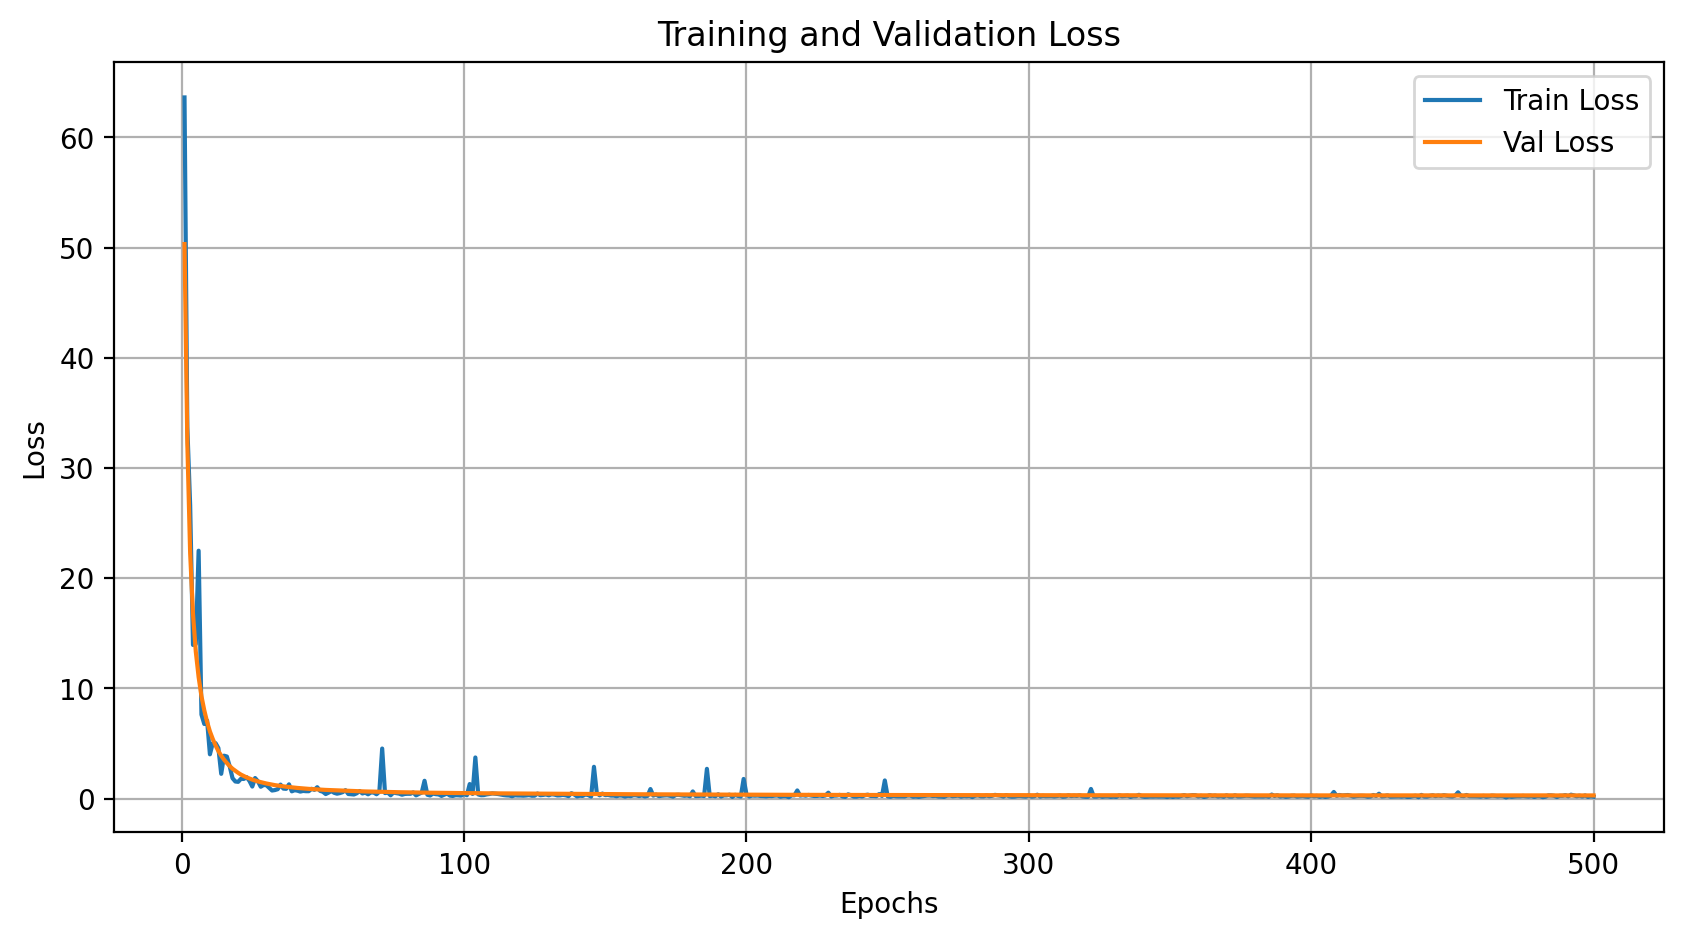

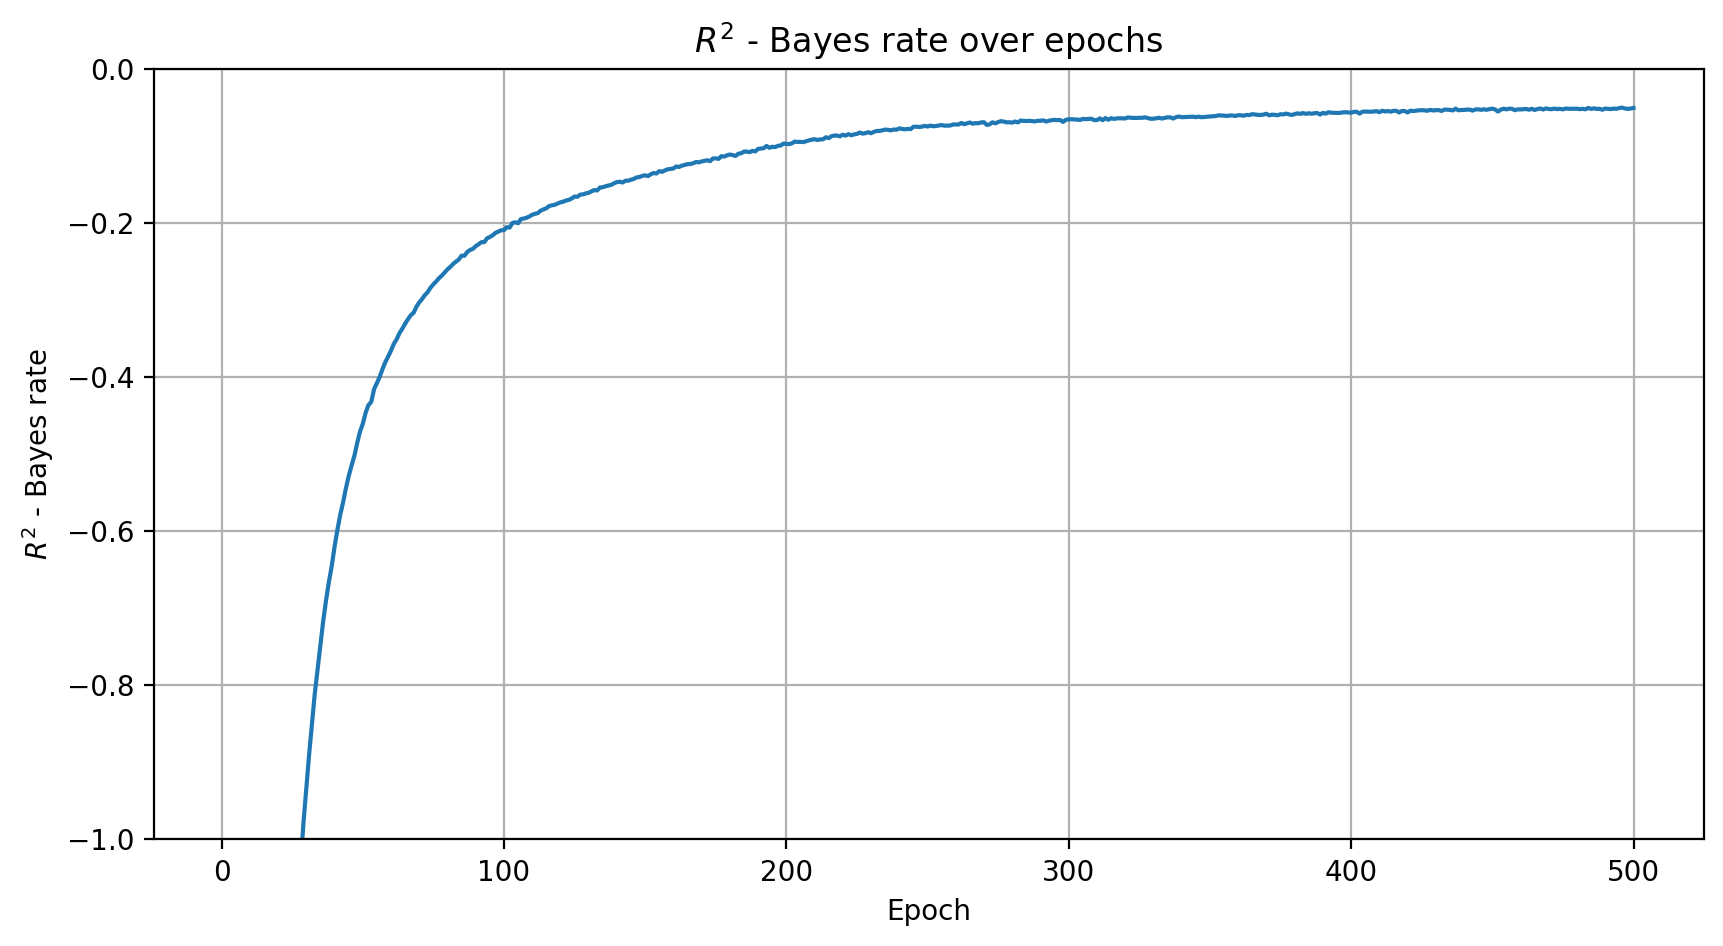

 - train_model() took 2.1691 mins to run


In [ ]:
train_model(model, criterion, train_loader, val_loader, test_loader, optimizer, n_epochs=500)
# train_model(model, criterion, train_loader, val_loader, test_loader, optimizer, n_epochs=500,
#             early_stopping=EarlyStopping(patience=10, verbose=False))

### Evaluate model

In [ ]:
name = f'NeuMiss depth-{neumiss_depth}'
result = create_results_df(model, val_loader, test_loader, name=name)
result

,Name,R2,MSE
0,NeuMiss depth-10_train,0.807217,0.207971
1,NeuMiss depth-10_val,0.748215,0.280781
2,NeuMiss depth-10_test,0.757780,0.267349


## Other results

### Compare NeuMiss with and without residual connection

NeuMiss depth-10, with residual connection
Epoch [10/500], Train loss: 6.8244, Validation loss: 7.4189
Epoch [20/500], Train loss: 2.8423, Validation loss: 2.9851
Epoch [30/500], Train loss: 1.5540, Validation loss: 1.5487
Epoch [40/500], Train loss: 0.8737, Validation loss: 1.0049
Epoch [50/500], Train loss: 0.8328, Validation loss: 0.7598
Epoch [60/500], Train loss: 0.4036, Validation loss: 0.6238
Epoch [70/500], Train loss: 0.4731, Validation loss: 0.5336
Epoch [80/500], Train loss: 0.4713, Validation loss: 0.4710
Epoch [90/500], Train loss: 0.2214, Validation loss: 0.4262
Epoch [100/500], Train loss: 0.3567, Validation loss: 0.3926
Epoch [110/500], Train loss: 0.4930, Validation loss: 0.3685
Epoch [120/500], Train loss: 0.3127, Validation loss: 0.3515
Epoch [130/500], Train loss: 0.2722, Validation loss: 0.3383
Epoch [140/500], Train loss: 0.3127, Validation loss: 0.3274
Epoch [150/500], Train loss: 0.3311, Validation loss: 0.3202
Epoch [160/500], Train loss: 0.3108, Validation los

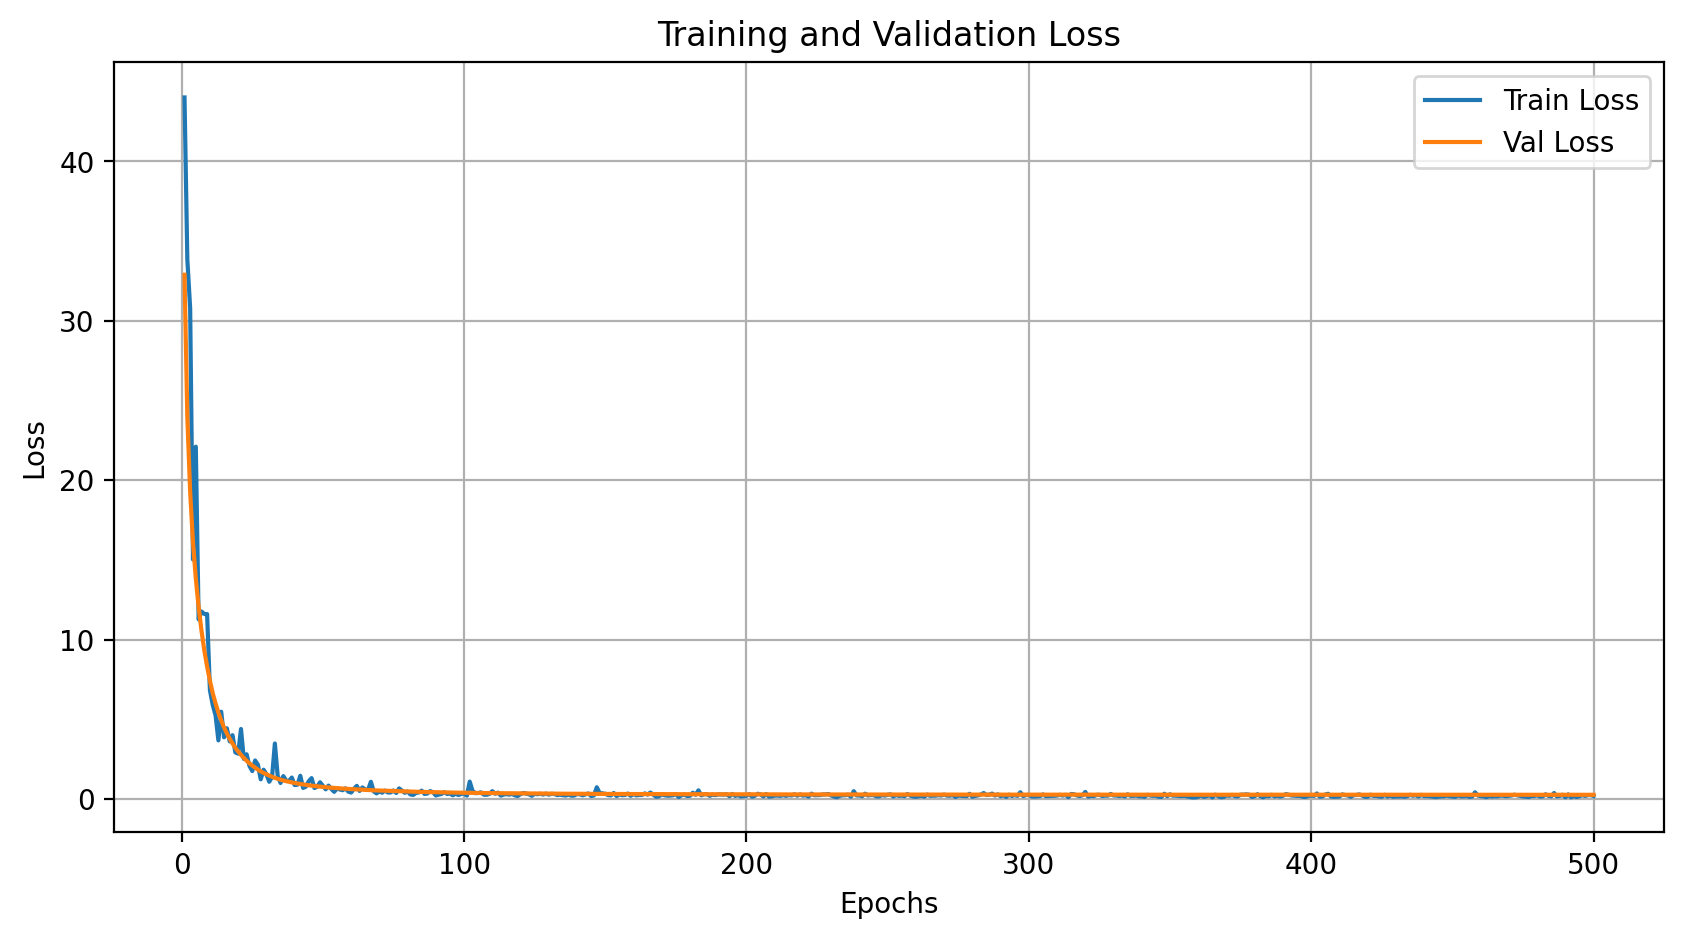

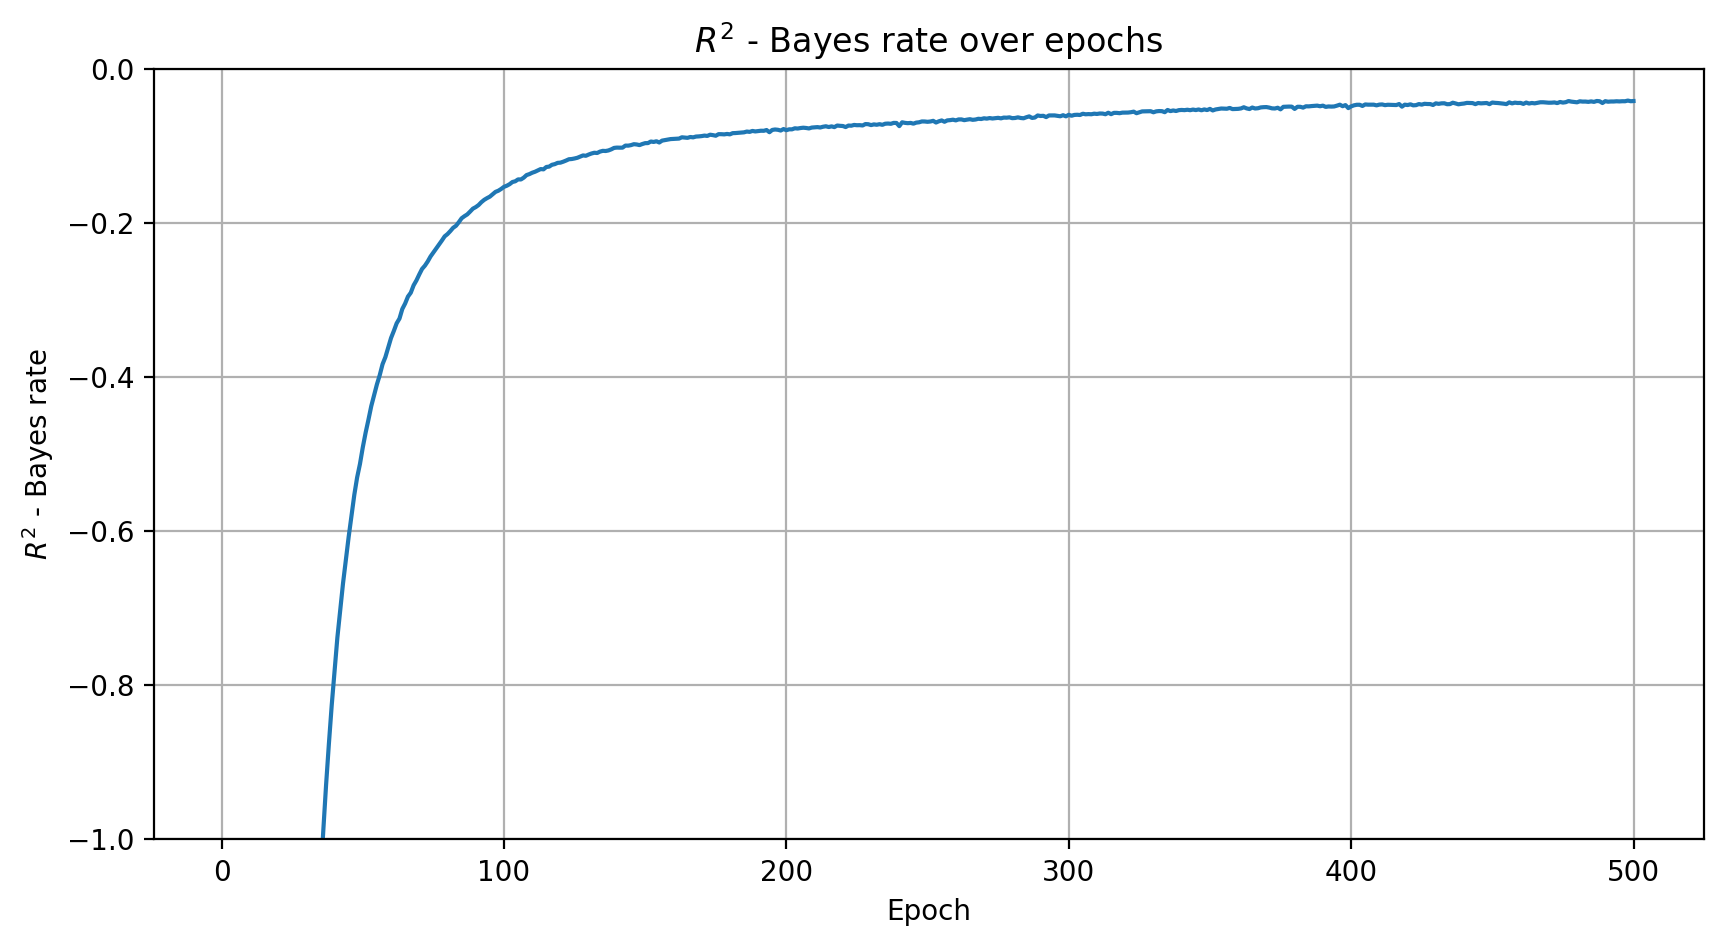

 - train_model() took 2.0093 mins to run
                                               Name        R2       MSE
0  NeuMiss depth-10, with residual connection_train  0.817474  0.196906
1    NeuMiss depth-10, with residual connection_val  0.763052  0.264235
2   NeuMiss depth-10, with residual connection_test  0.766745  0.257454
NeuMiss depth-10, without residual connection
Epoch [10/500], Train loss: 5.4527, Validation loss: 6.0474
Epoch [20/500], Train loss: 3.5120, Validation loss: 3.1047
Epoch [30/500], Train loss: 1.5507, Validation loss: 1.8388
Epoch [40/500], Train loss: 1.2273, Validation loss: 1.1948
Epoch [50/500], Train loss: 0.7671, Validation loss: 0.8626
Epoch [60/500], Train loss: 0.3569, Validation loss: 0.6981
Epoch [70/500], Train loss: 0.4825, Validation loss: 0.5994
Epoch [80/500], Train loss: 0.3468, Validation loss: 0.5418
Epoch [90/500], Train loss: 0.2655, Validation loss: 0.4992
Epoch [100/500], Train loss: 0.5523, Validation loss: 0.4655
Epoch [110/500], Train l

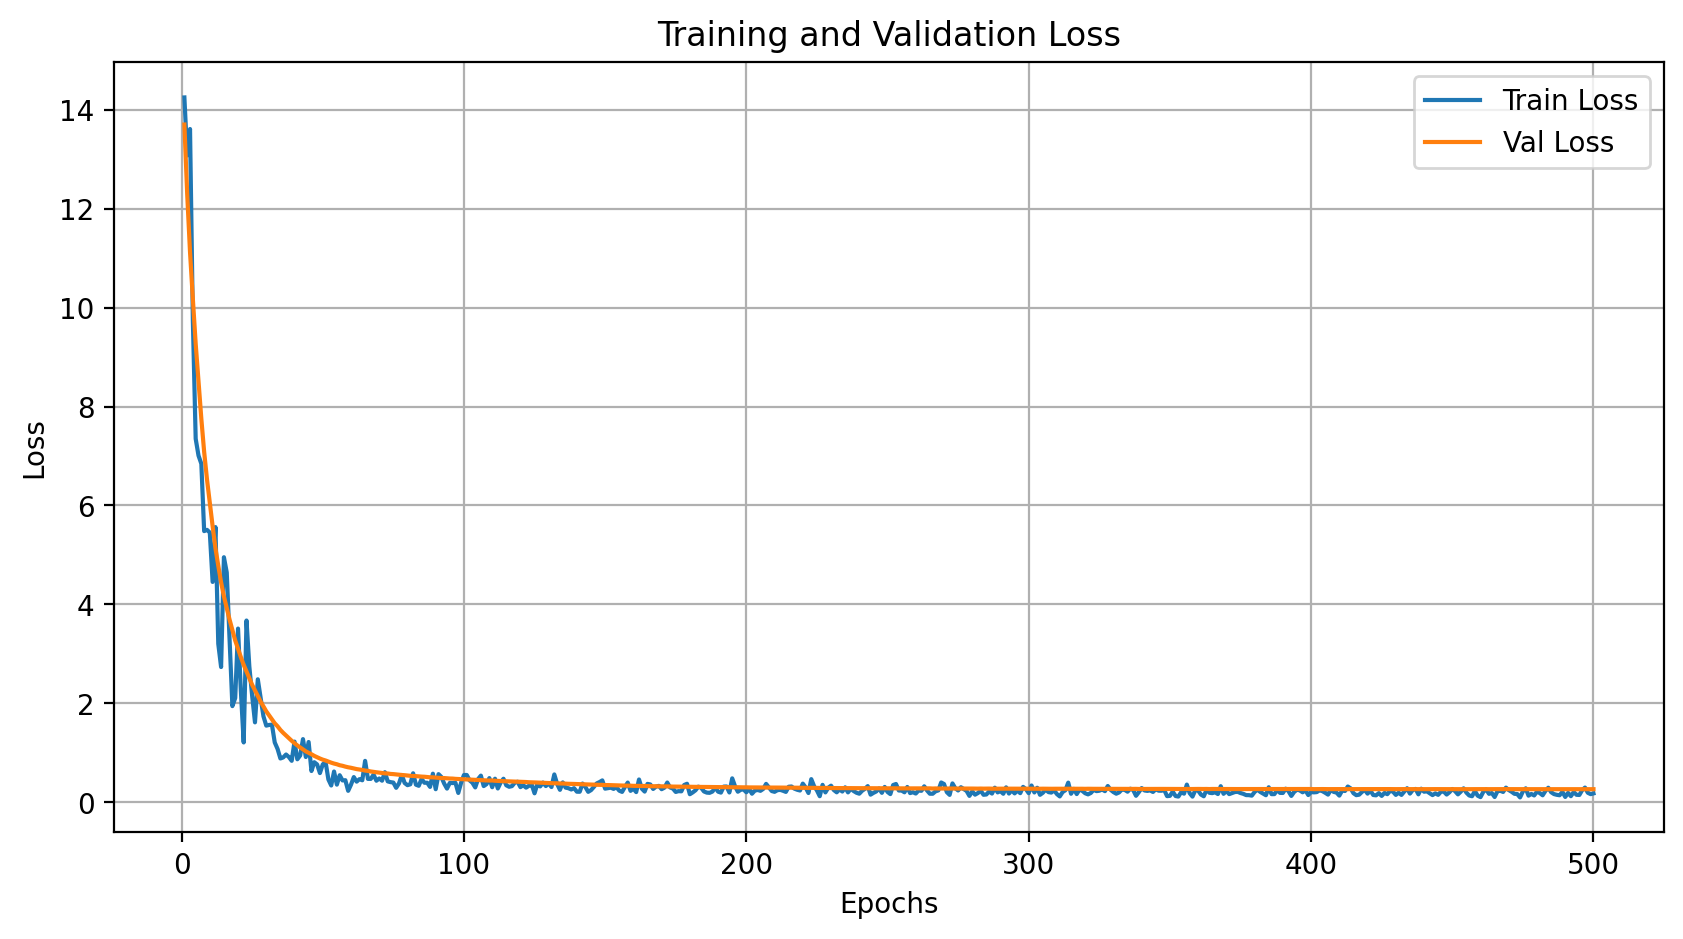

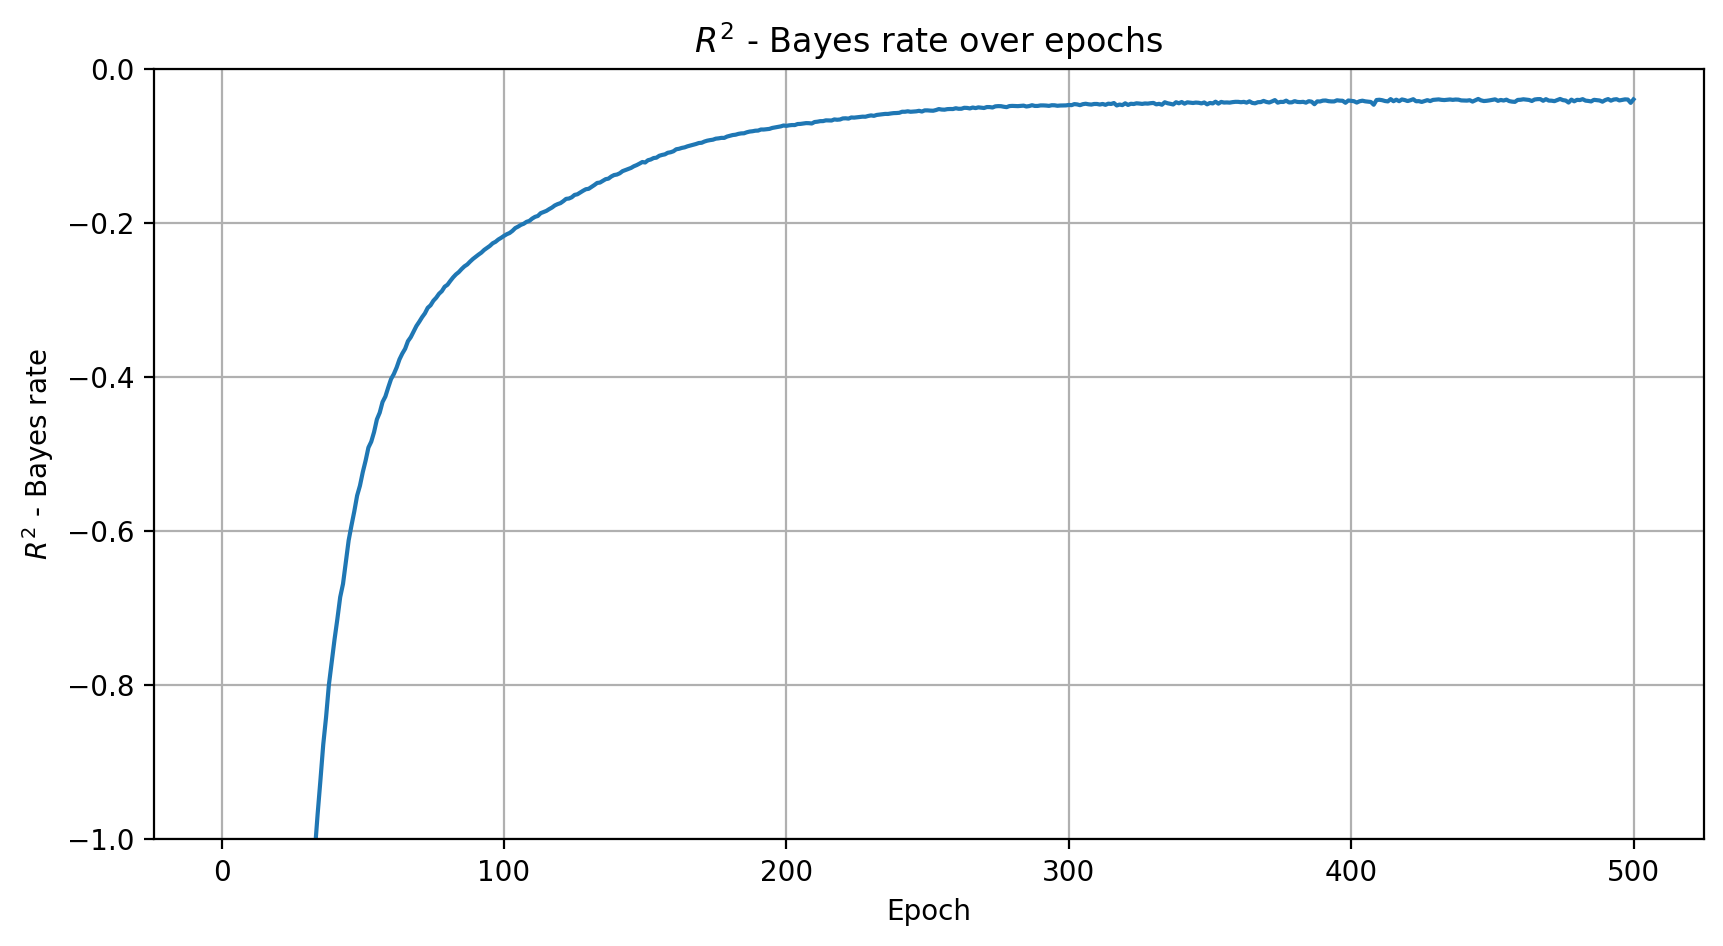

 - train_model() took 2.1236 mins to run
                                                Name        R2       MSE
0  NeuMiss depth-10, without residual connection_...  0.821440  0.192628
1  NeuMiss depth-10, without residual connection_val  0.761934  0.265482
2  NeuMiss depth-10, without residual connection_...  0.768893  0.255083


,Name,R2,MSE
0,"NeuMiss depth-10, with residual connection_train",0.817474,0.196906
1,"NeuMiss depth-10, with residual connection_val",0.763052,0.264235
2,"NeuMiss depth-10, with residual connection_test",0.766745,0.257454
3,"NeuMiss depth-10, without residual connection_...",0.821440,0.192628
4,"NeuMiss depth-10, without residual connection_val",0.761934,0.265482
5,"NeuMiss depth-10, without residual connection_...",0.768893,0.255083


In [ ]:
neumiss_depth = 10
name = 'NeuMiss depth-10, with residual connection'
print(name)
model = NeuMiss(n_features=d, depth=neumiss_depth, residual_connection=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, criterion, train_loader, val_loader, test_loader, optimizer, n_epochs=500)
result1 = create_results_df(model, val_loader, test_loader, name=name)
print(result1)

name = 'NeuMiss depth-10, without residual connection'
print(name)
model = NeuMiss(n_features=d, depth=neumiss_depth, residual_connection=False)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, criterion, train_loader, val_loader, test_loader, optimizer, n_epochs=500)
result2 = create_results_df(model, val_loader, test_loader, name=name)
print(result2)

result = pd.concat([result1, result2], ignore_index=True, sort=False)
result

### Different depths

NeuMiss depth-1


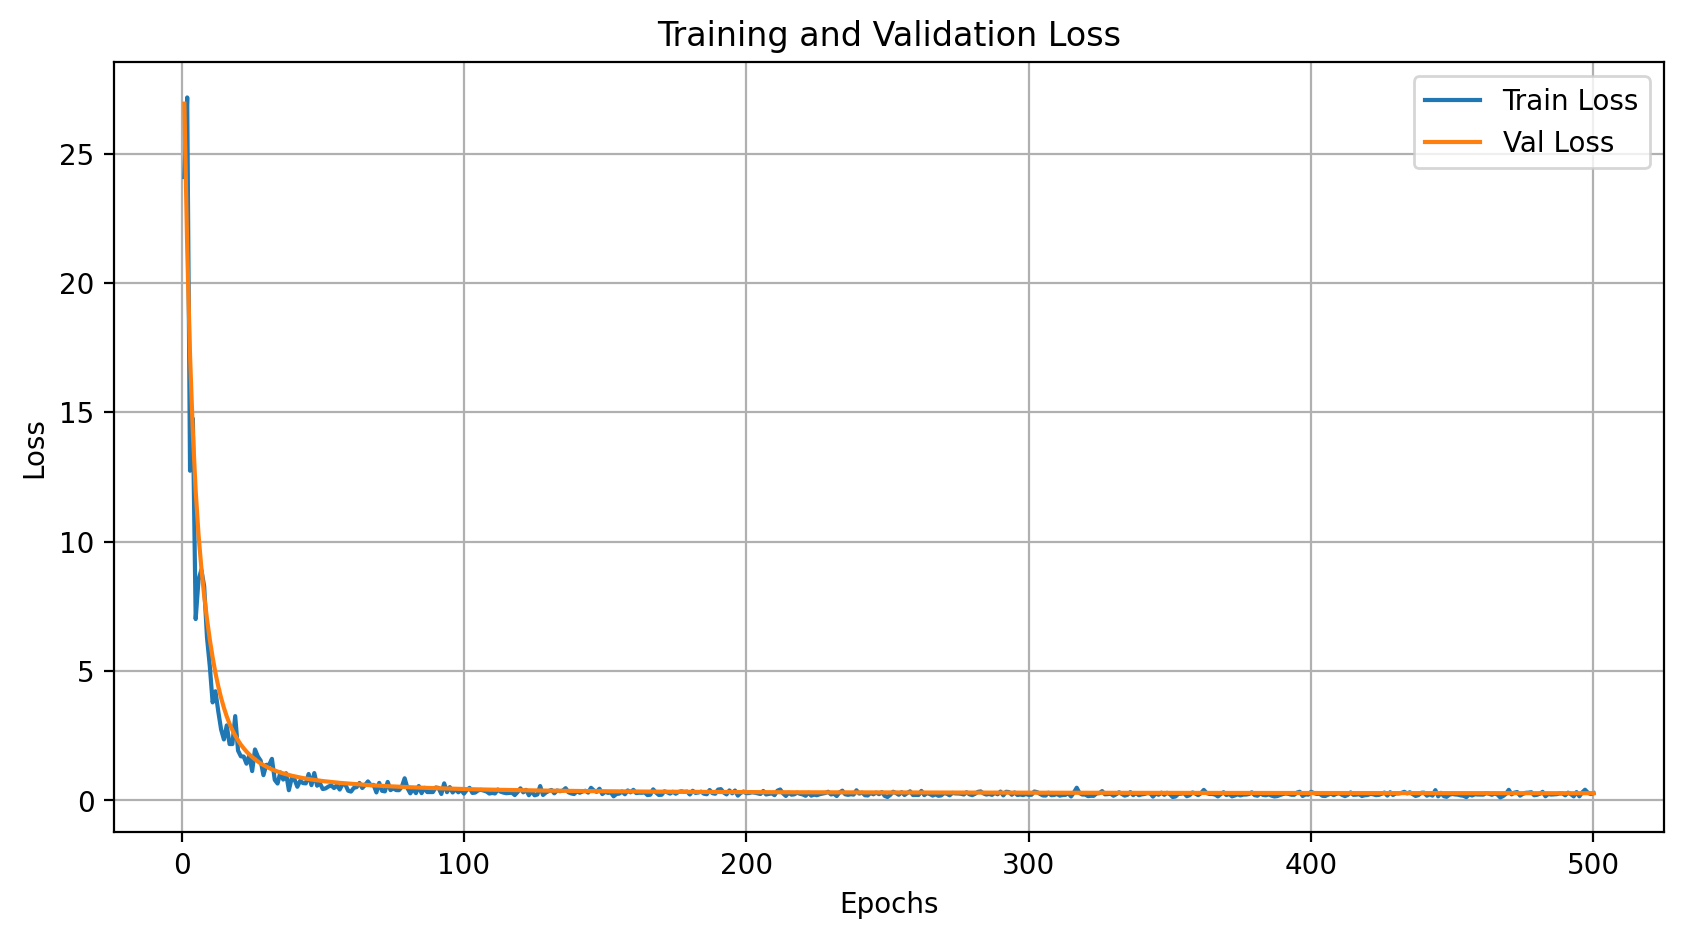

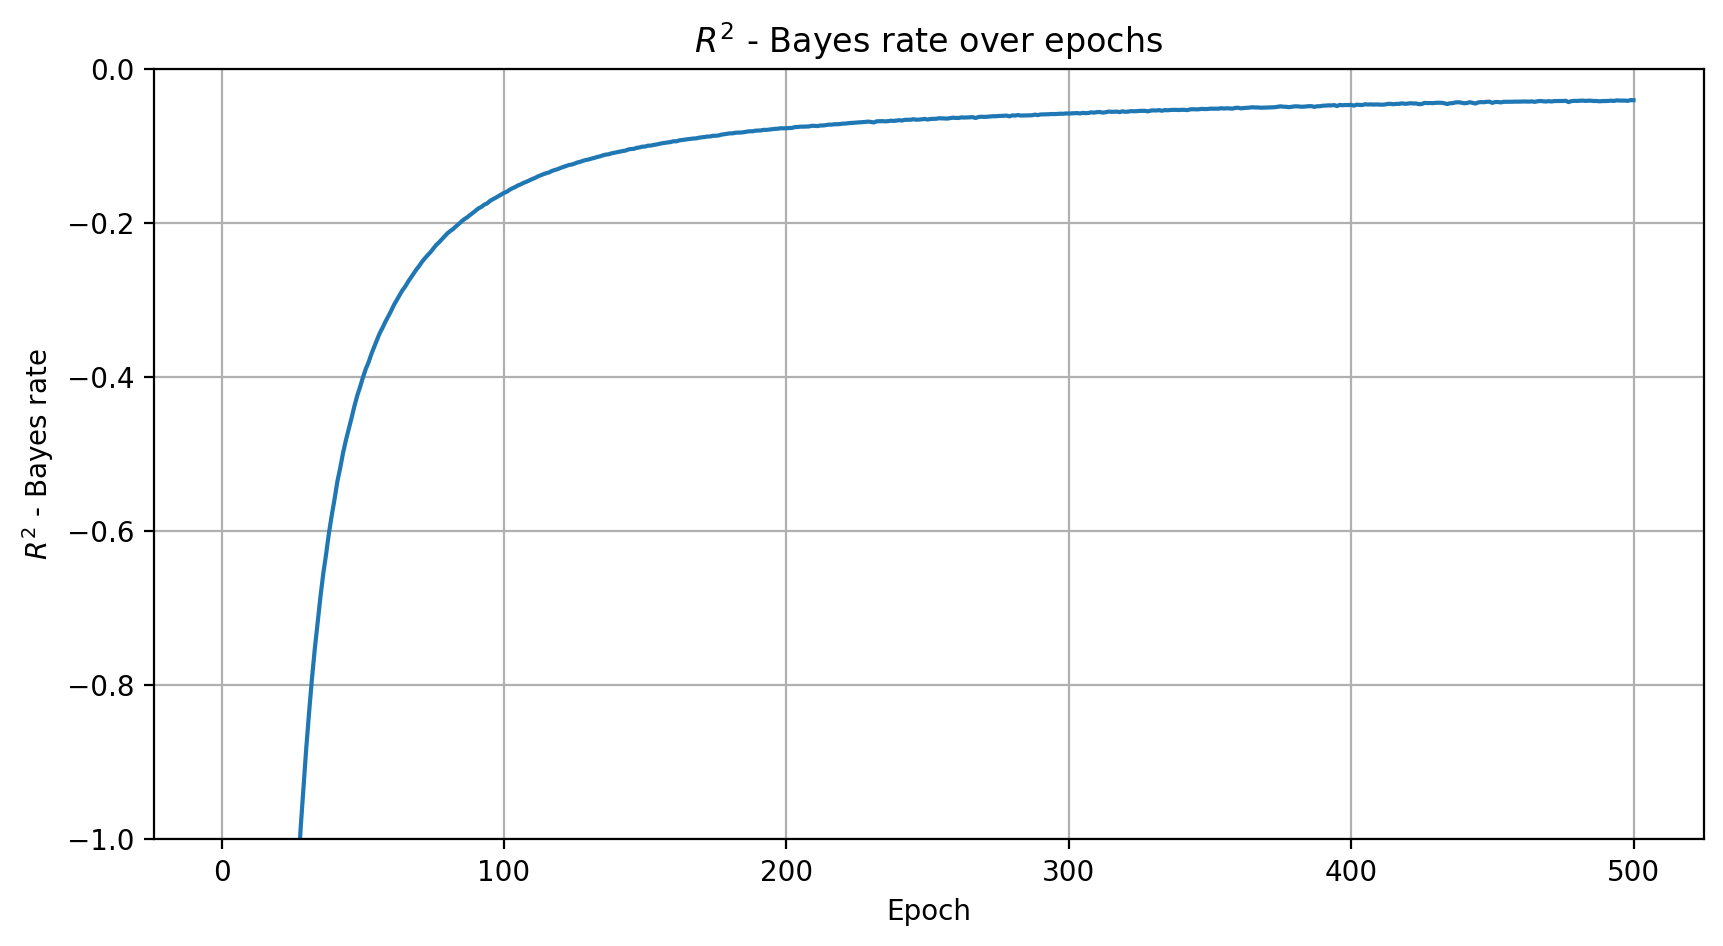

 - train_model() took 1.4322 mins to run
NeuMiss depth-5


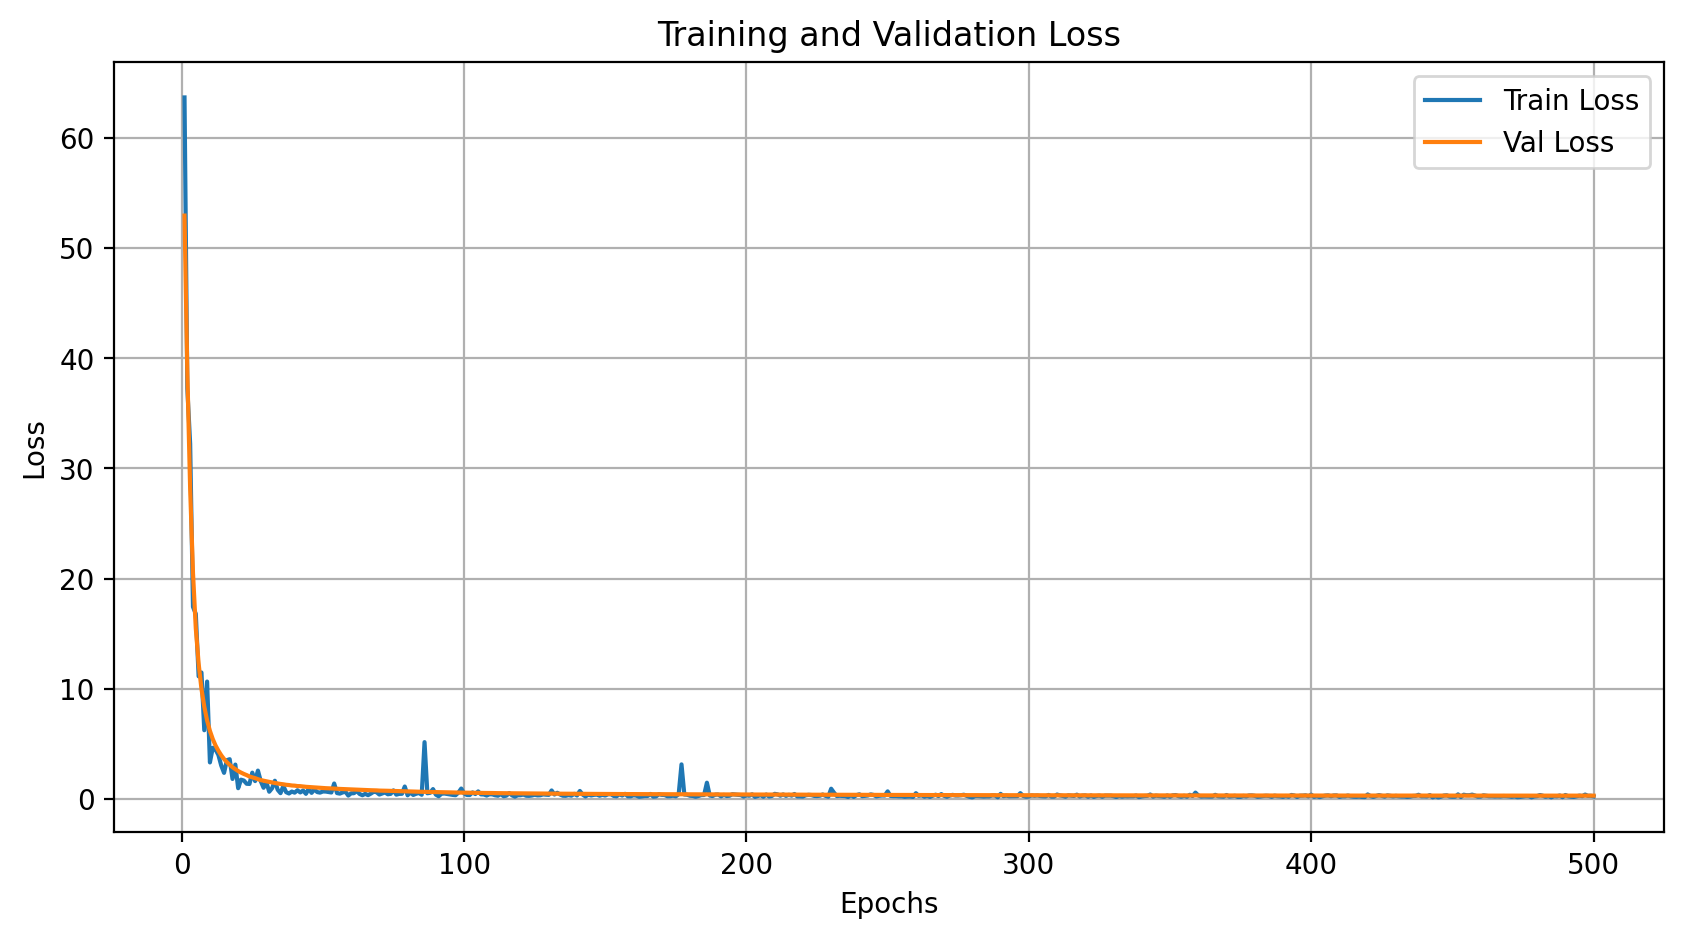

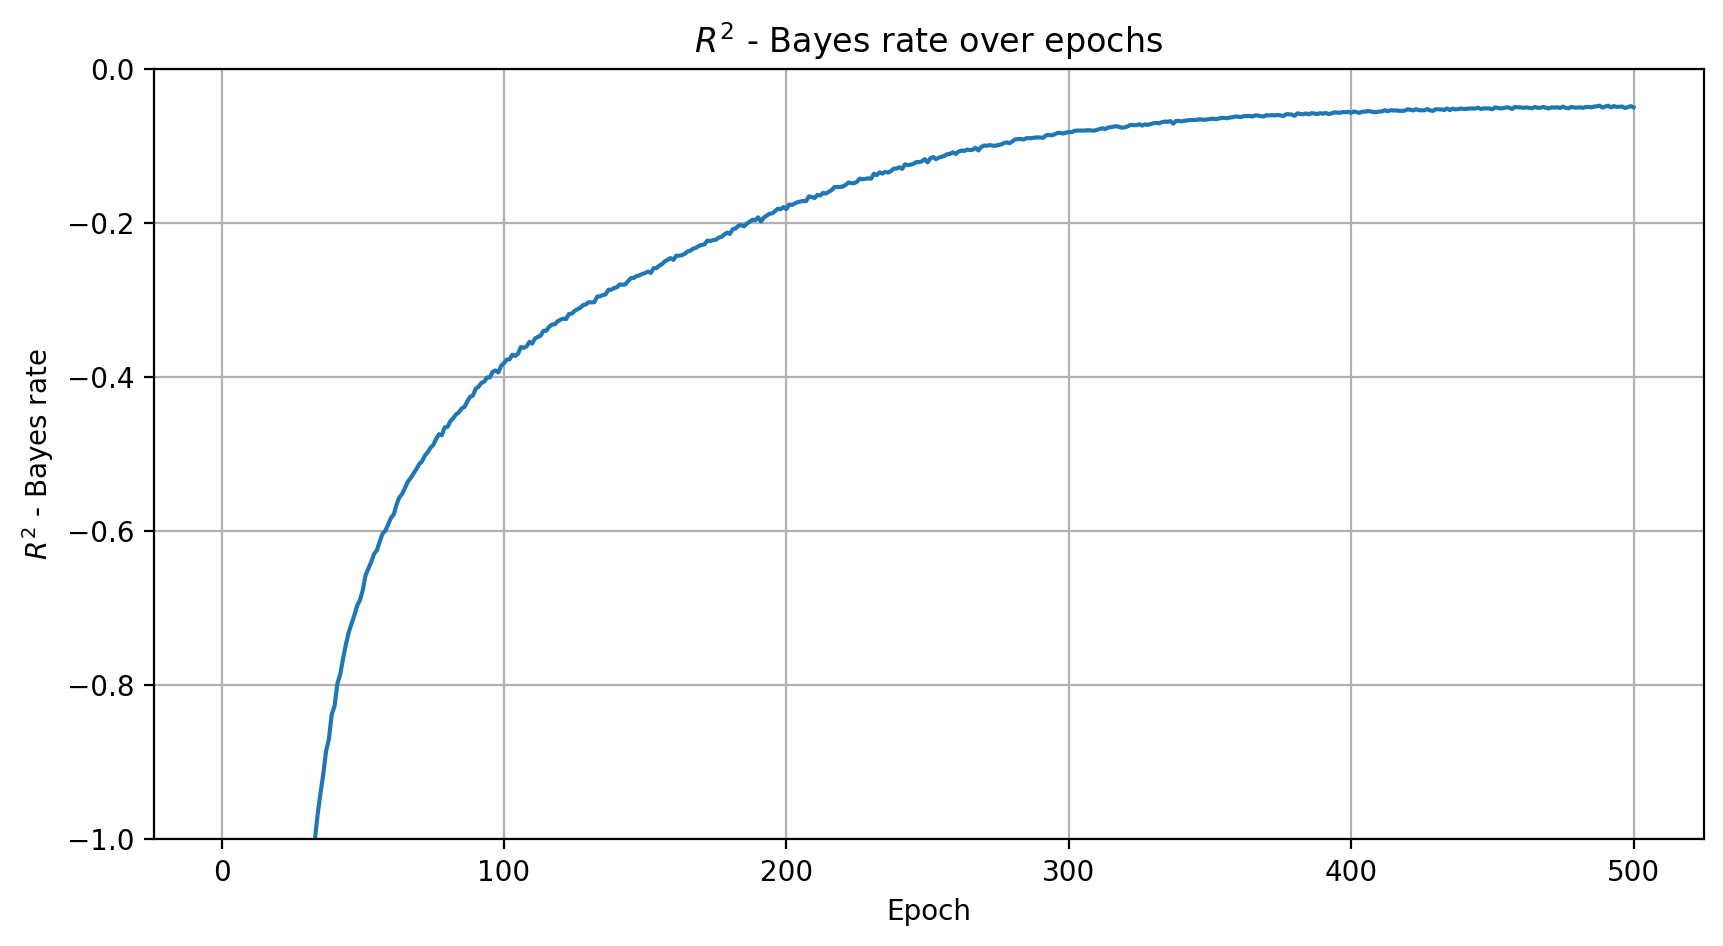

 - train_model() took 1.7484 mins to run
NeuMiss depth-10


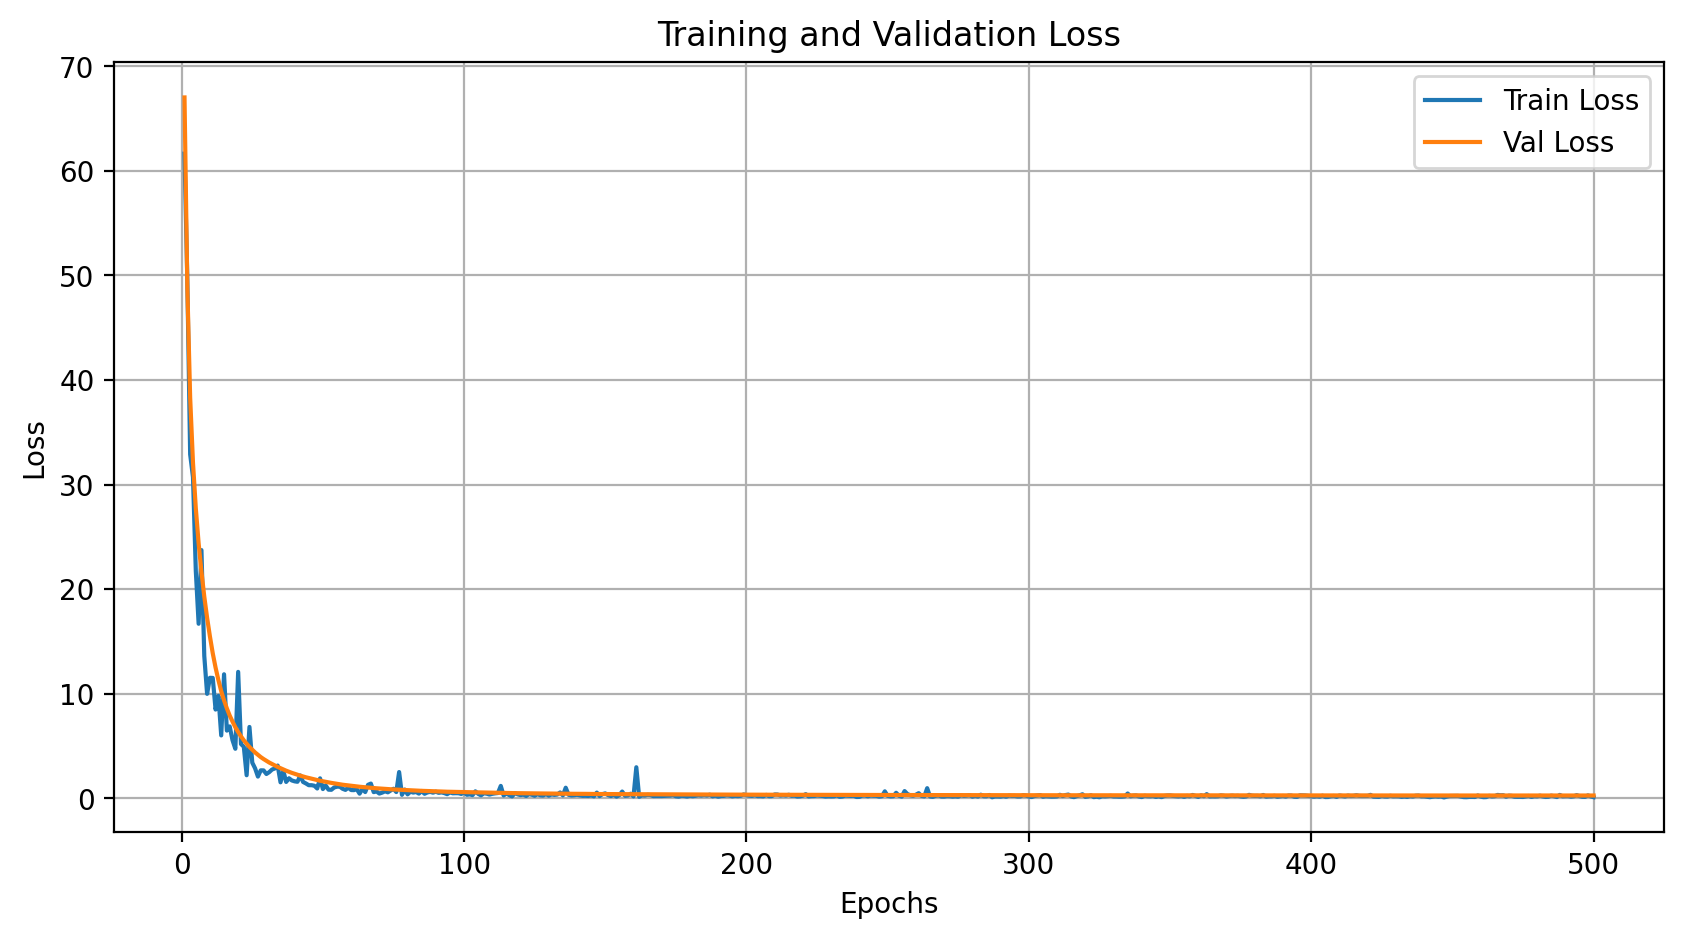

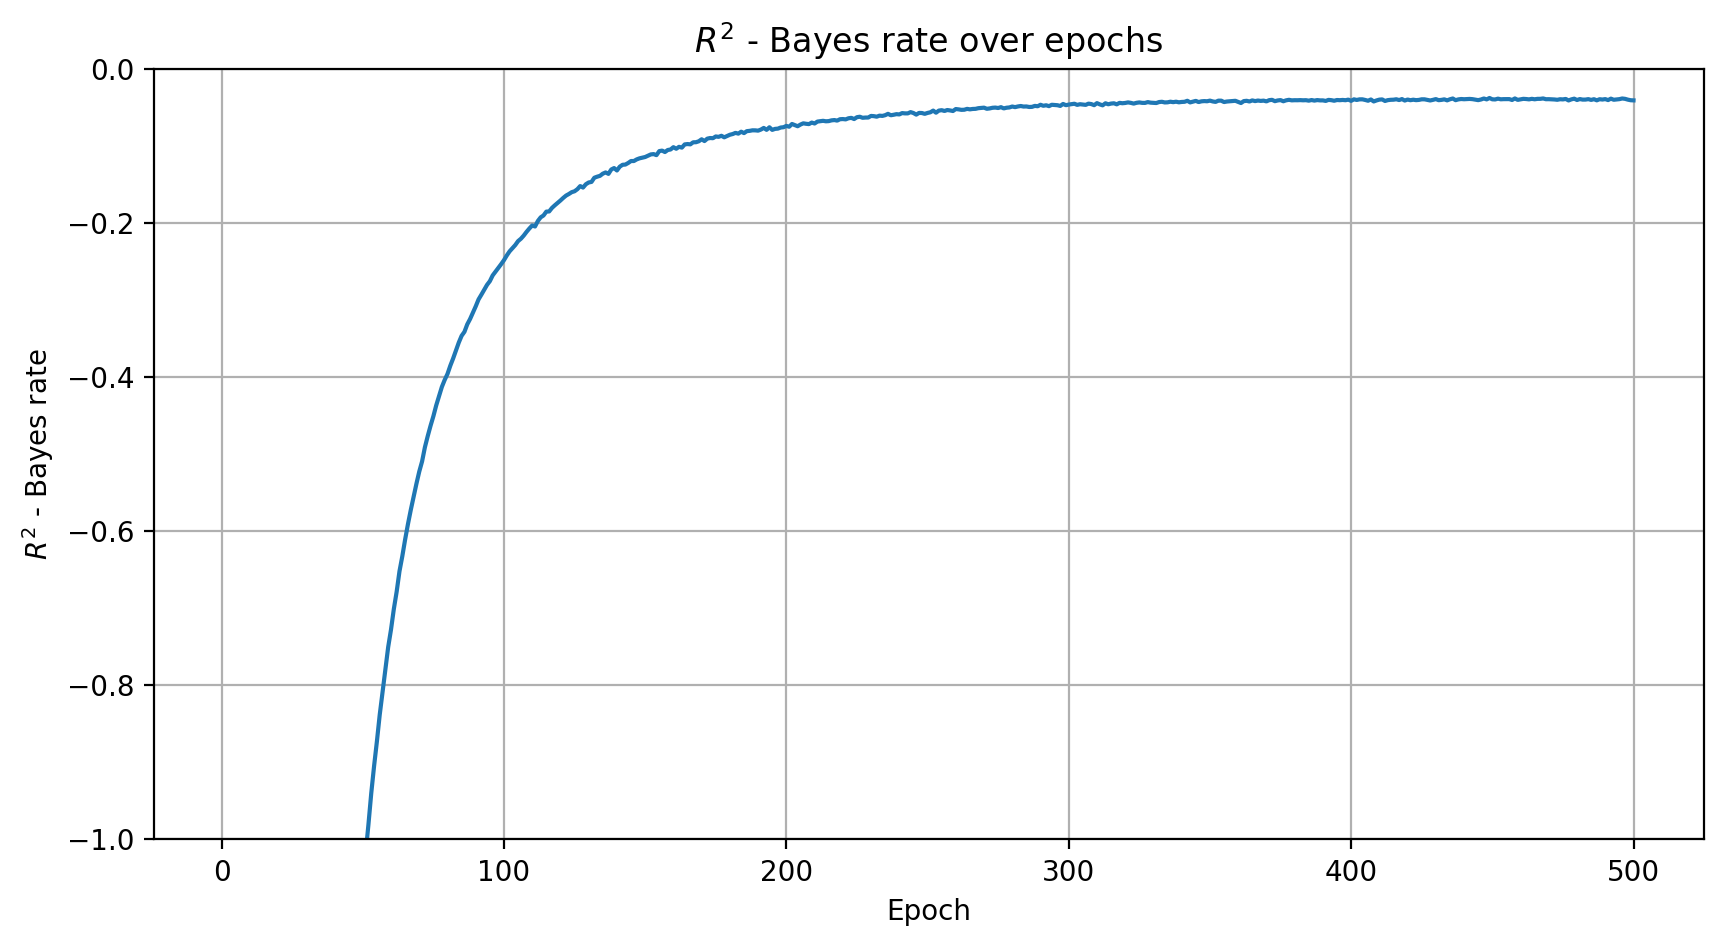

 - train_model() took 2.3376 mins to run
NeuMiss depth-15


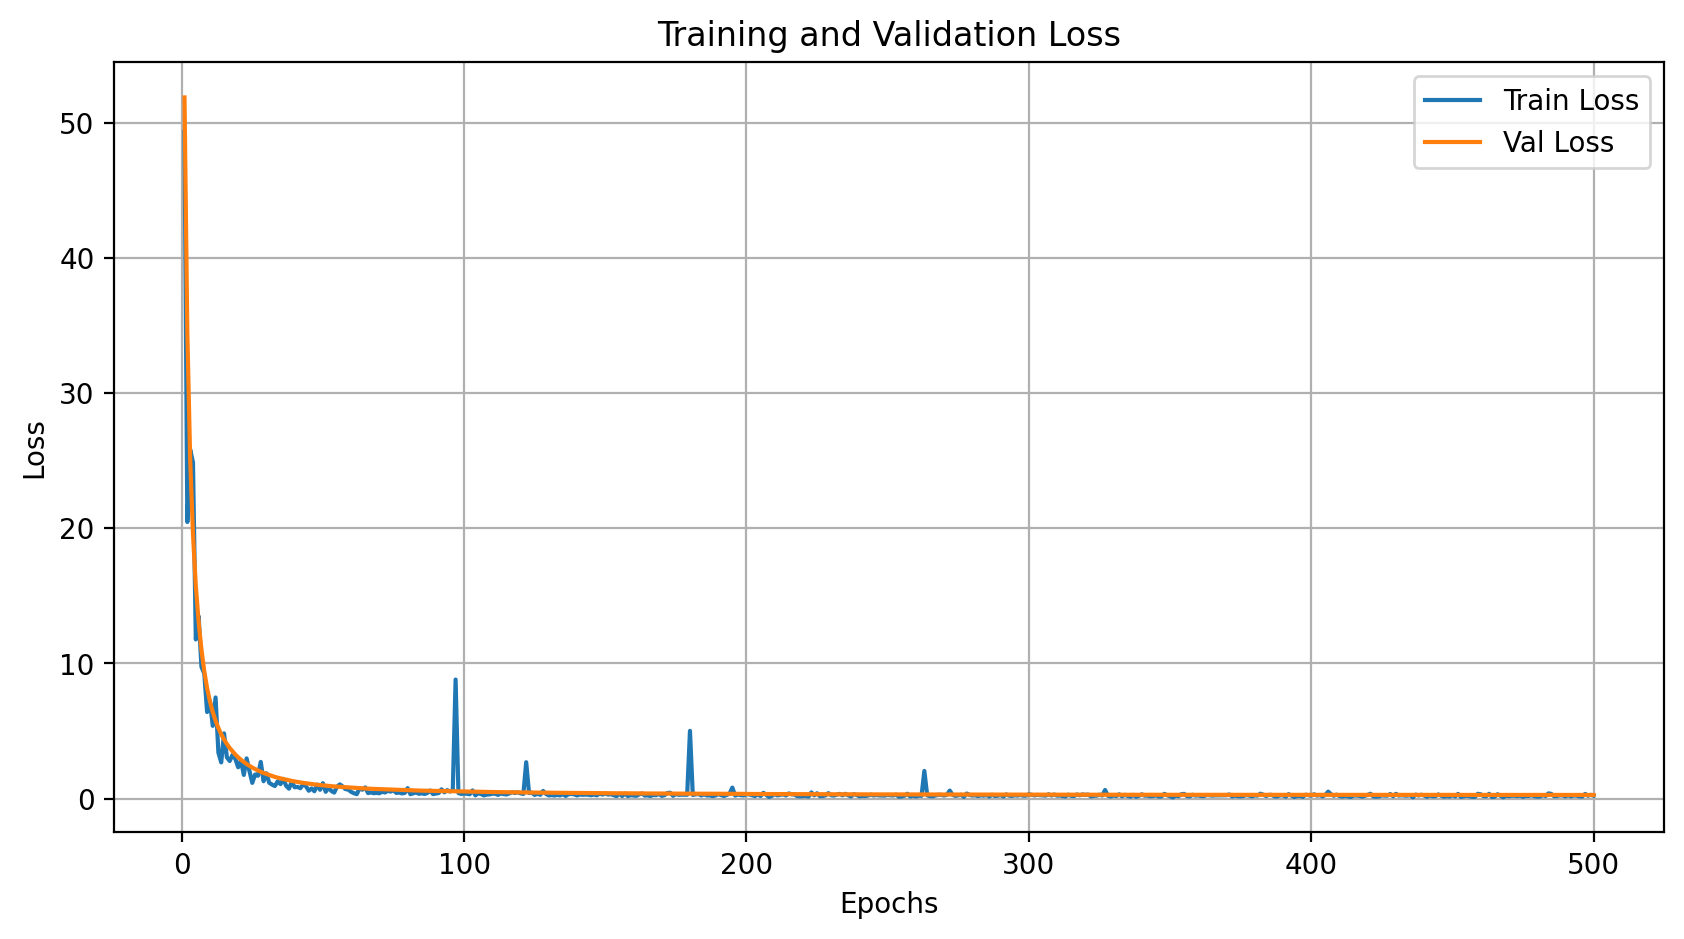

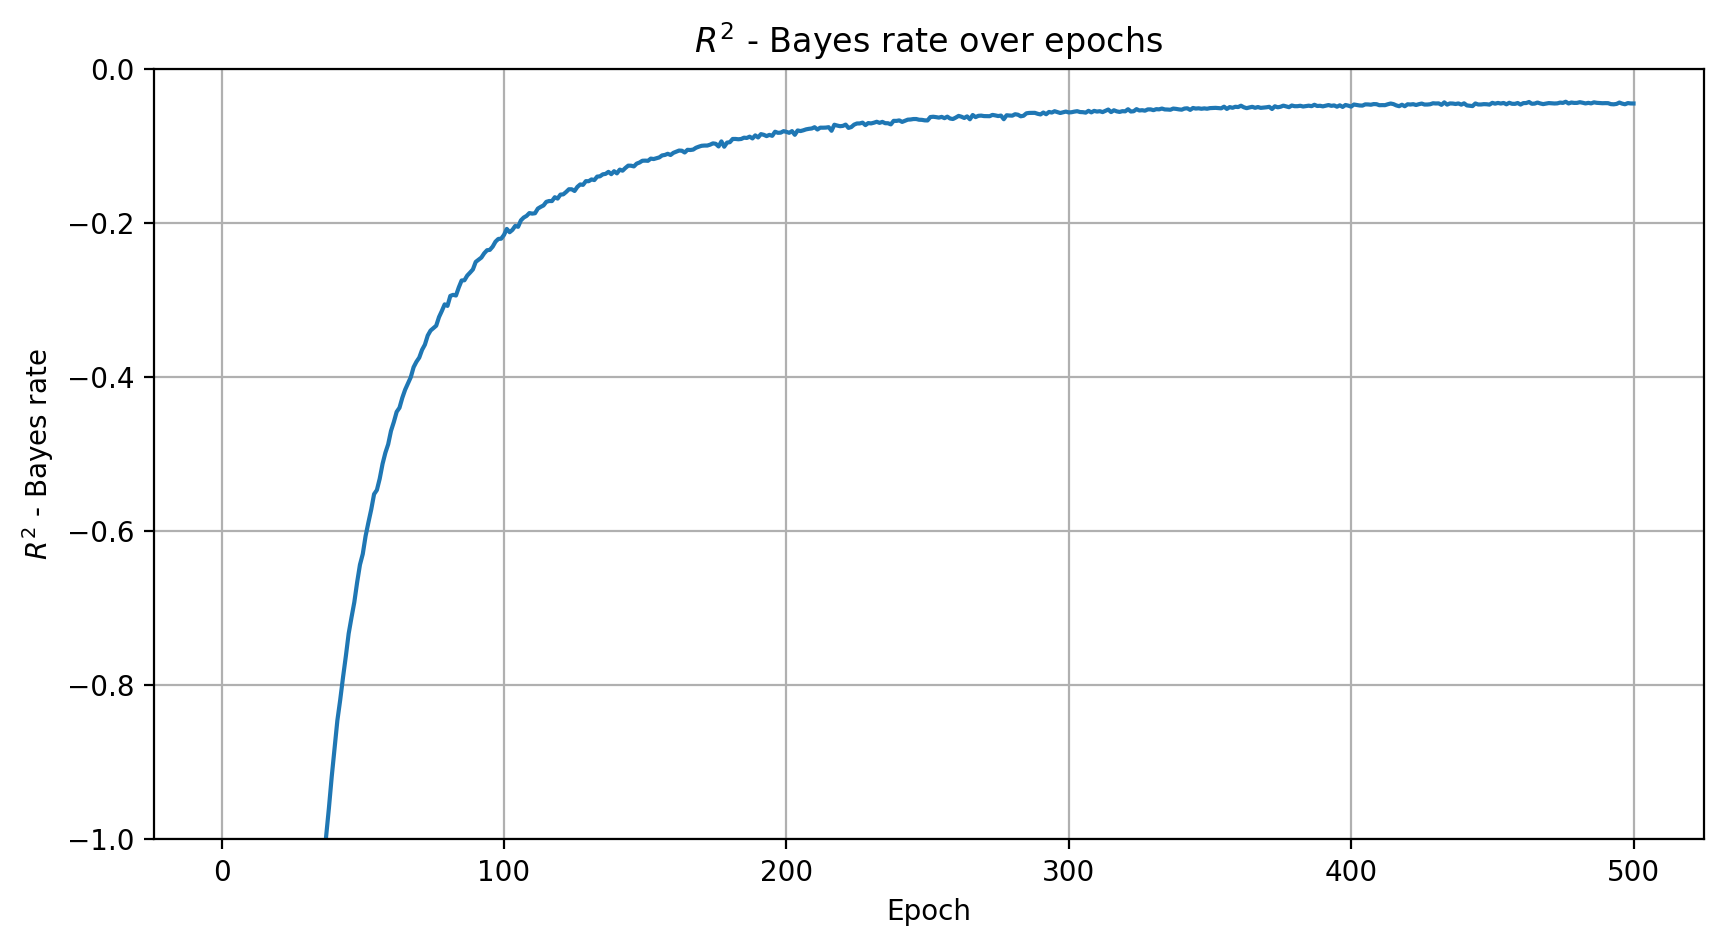

 - train_model() took 2.3565 mins to run
NeuMiss depth-20


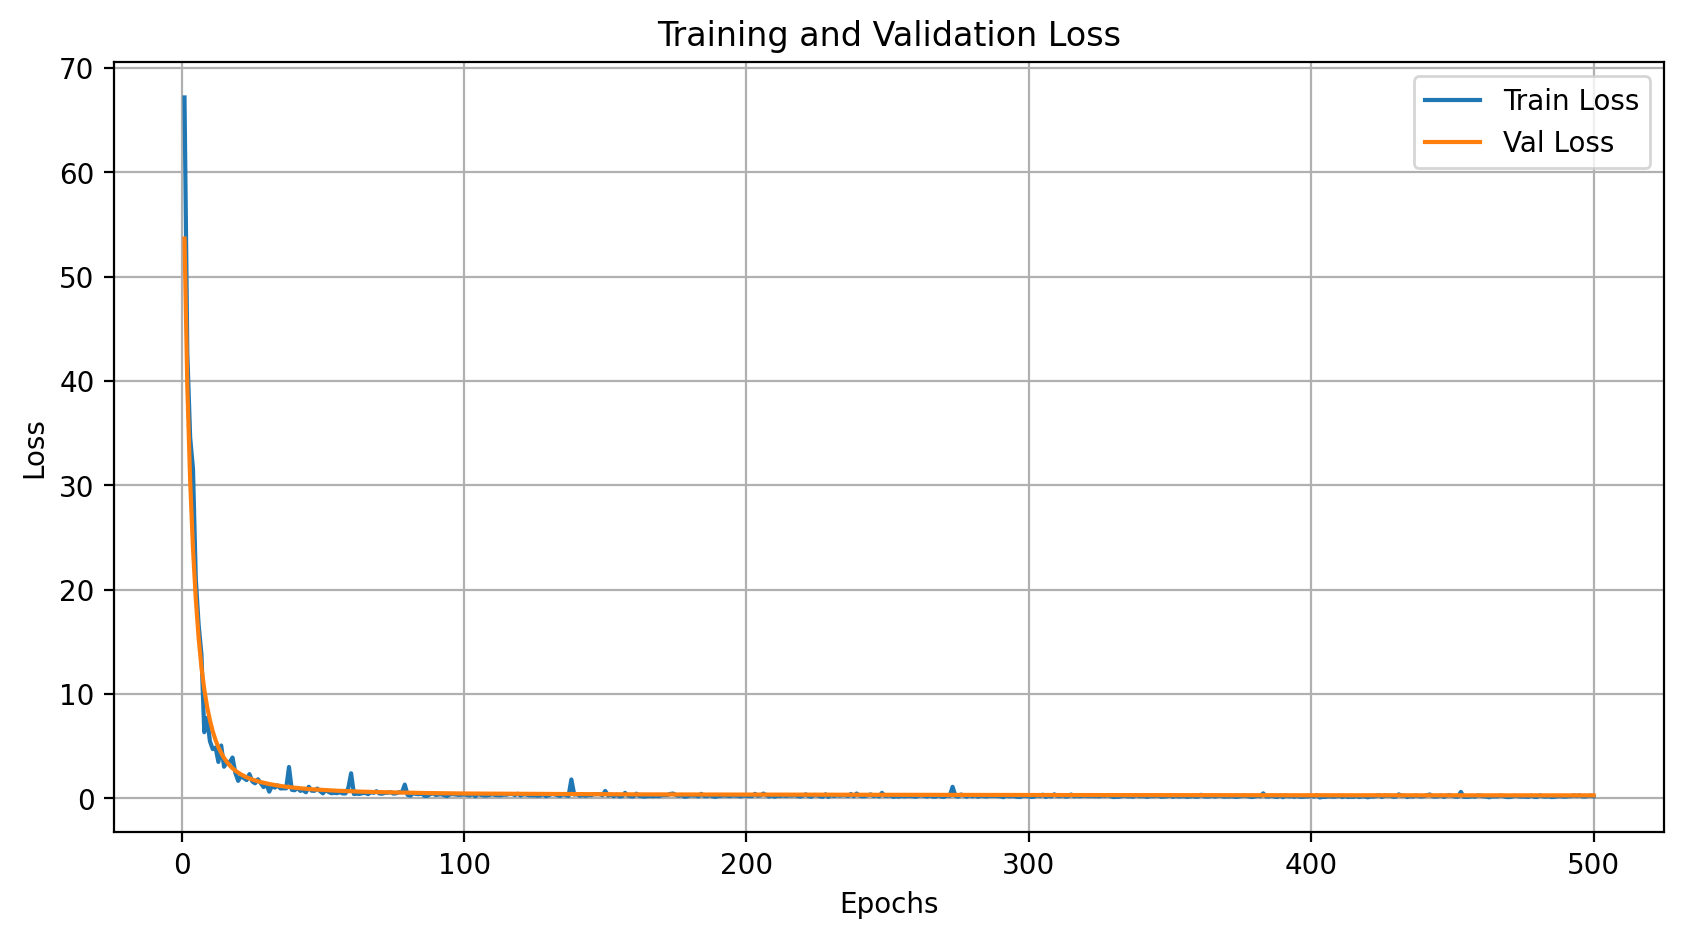

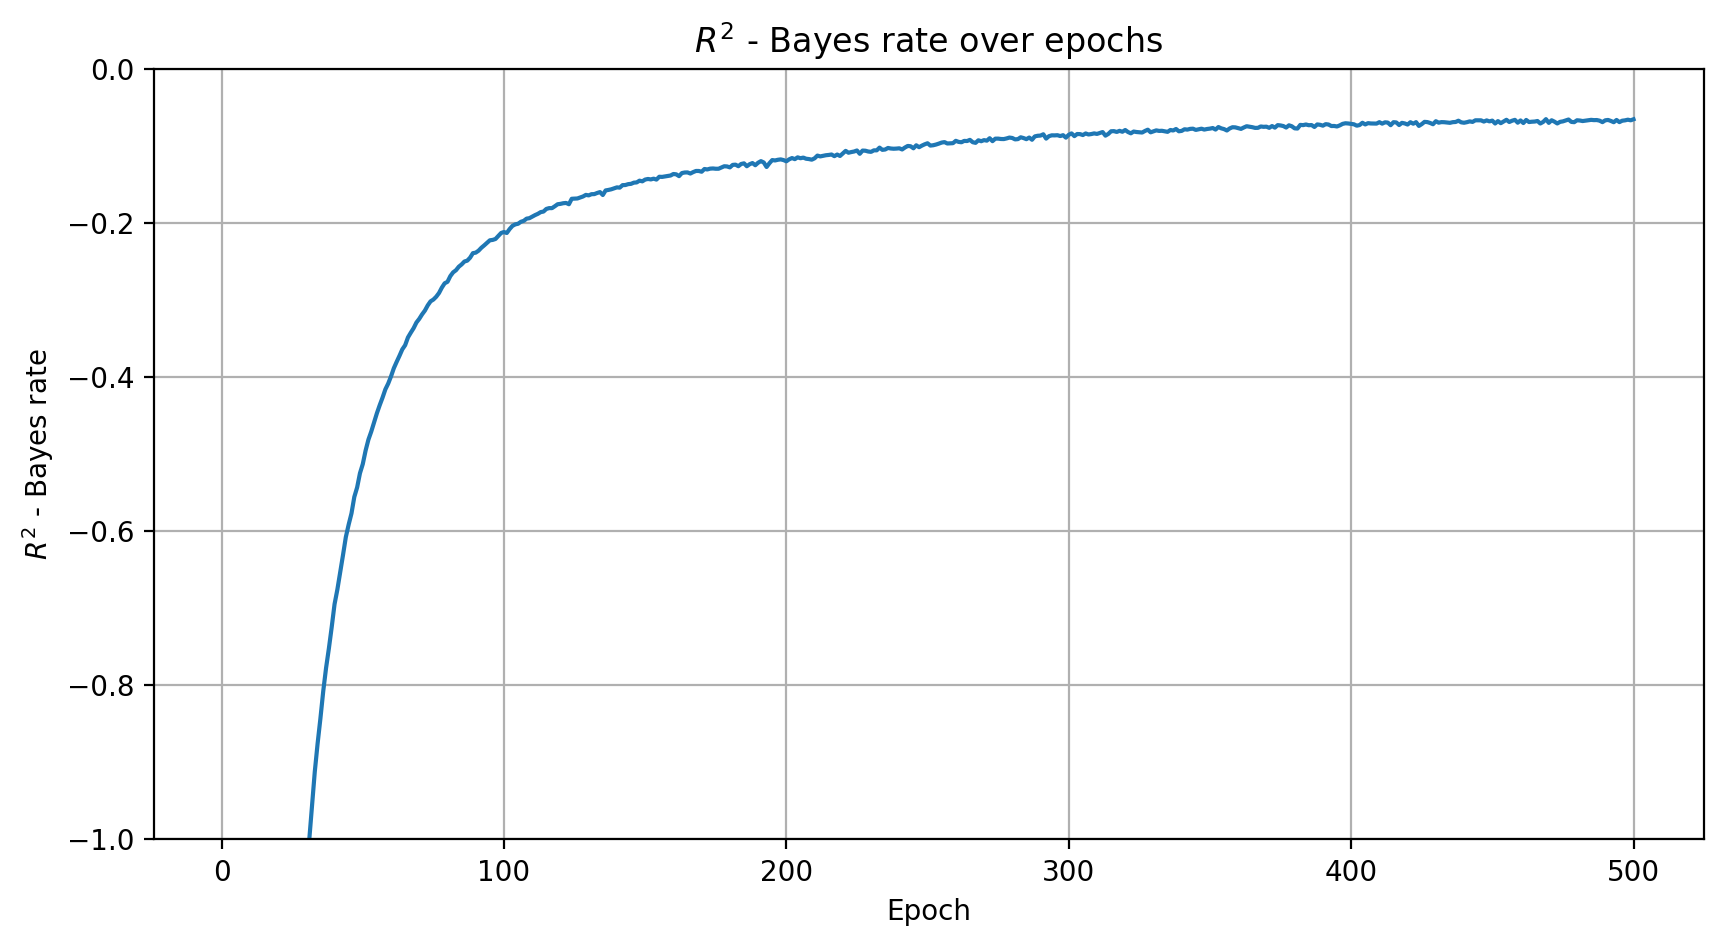

 - train_model() took 2.5817 mins to run


,Name,R2,MSE
0,NeuMiss depth-1_train,0.782282,0.234871
1,NeuMiss depth-1_val,0.750002,0.278787
2,NeuMiss depth-1_test,0.767834,0.256252
3,NeuMiss depth-5_train,0.795894,0.220187
4,NeuMiss depth-5_val,0.749236,0.279642
5,NeuMiss depth-5_test,0.758609,0.266434
6,NeuMiss depth-10_train,0.819130,0.195119
7,NeuMiss depth-10_val,0.754788,0.273450
8,NeuMiss depth-10_test,0.767617,0.256492
9,NeuMiss depth-15_train,0.816437,0.198025


In [ ]:
result = pd.DataFrame()

for neumiss_depth in [1, 5, 10, 15, 20]:
    name = f'NeuMiss depth-{neumiss_depth}'
    print(name)
    model = NeuMiss(n_features=d, depth=neumiss_depth, residual_connection=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_model(model, criterion, train_loader, val_loader, test_loader,
                optimizer, n_epochs=500, verbose=False)
    new_result = create_results_df(model, val_loader, test_loader, name=name)
    result = pd.concat([result, new_result], ignore_index=True, sort=False)

result

### Different missing rates

NeuMiss depth-10 on missing rate 0.1:


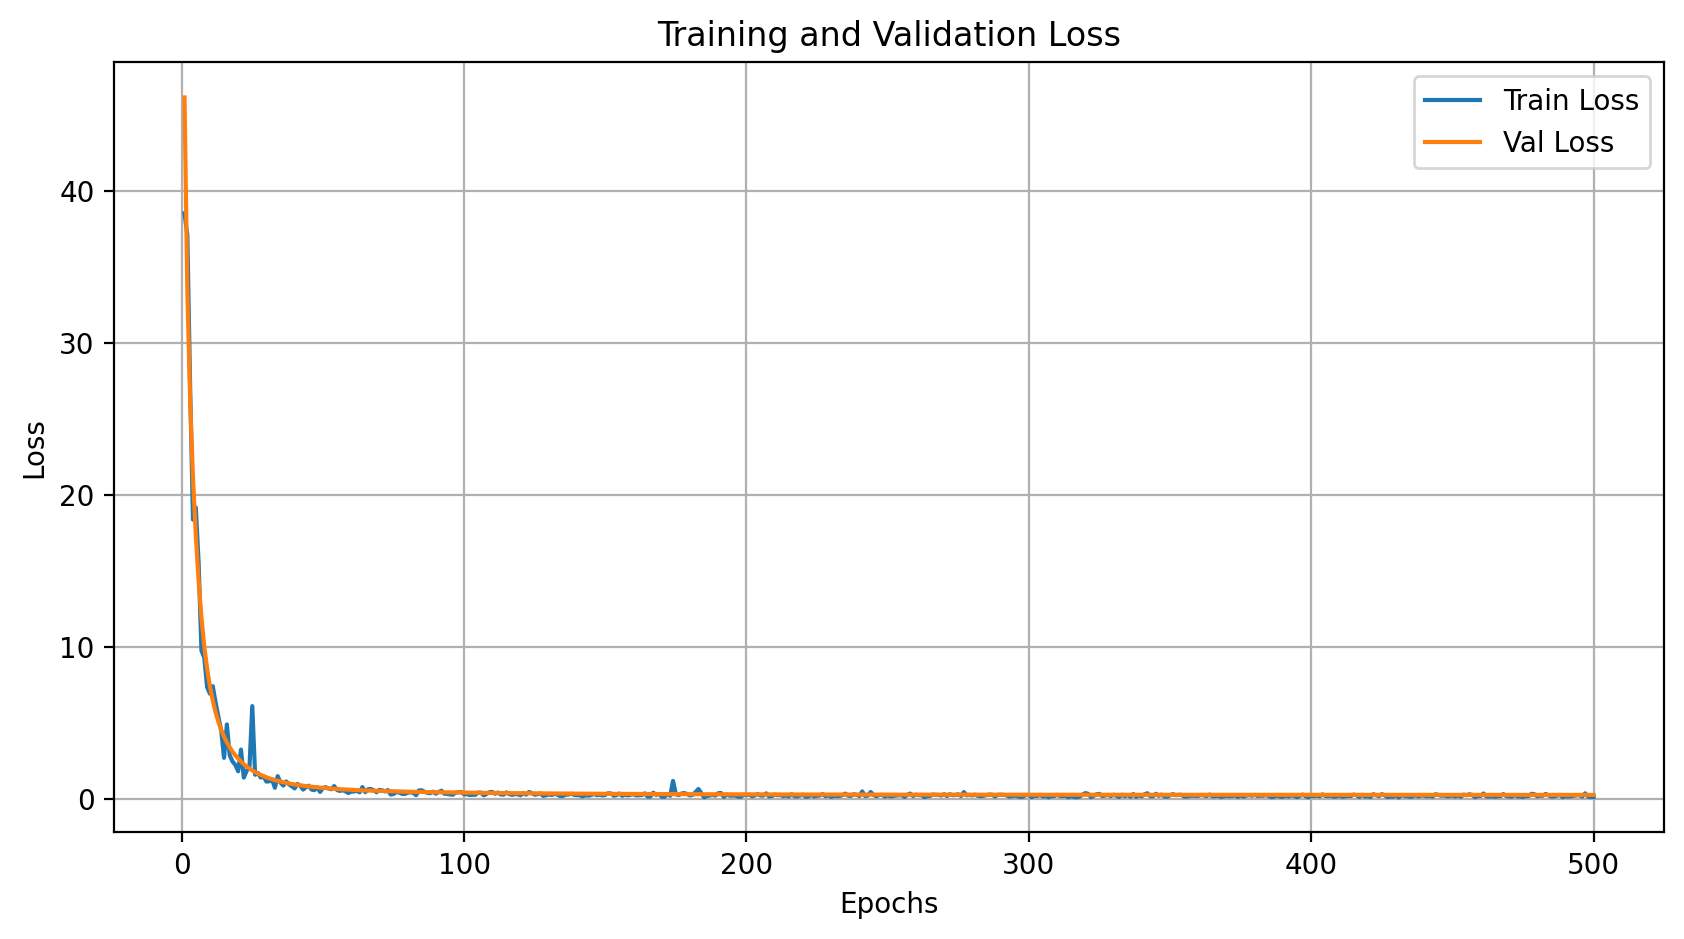

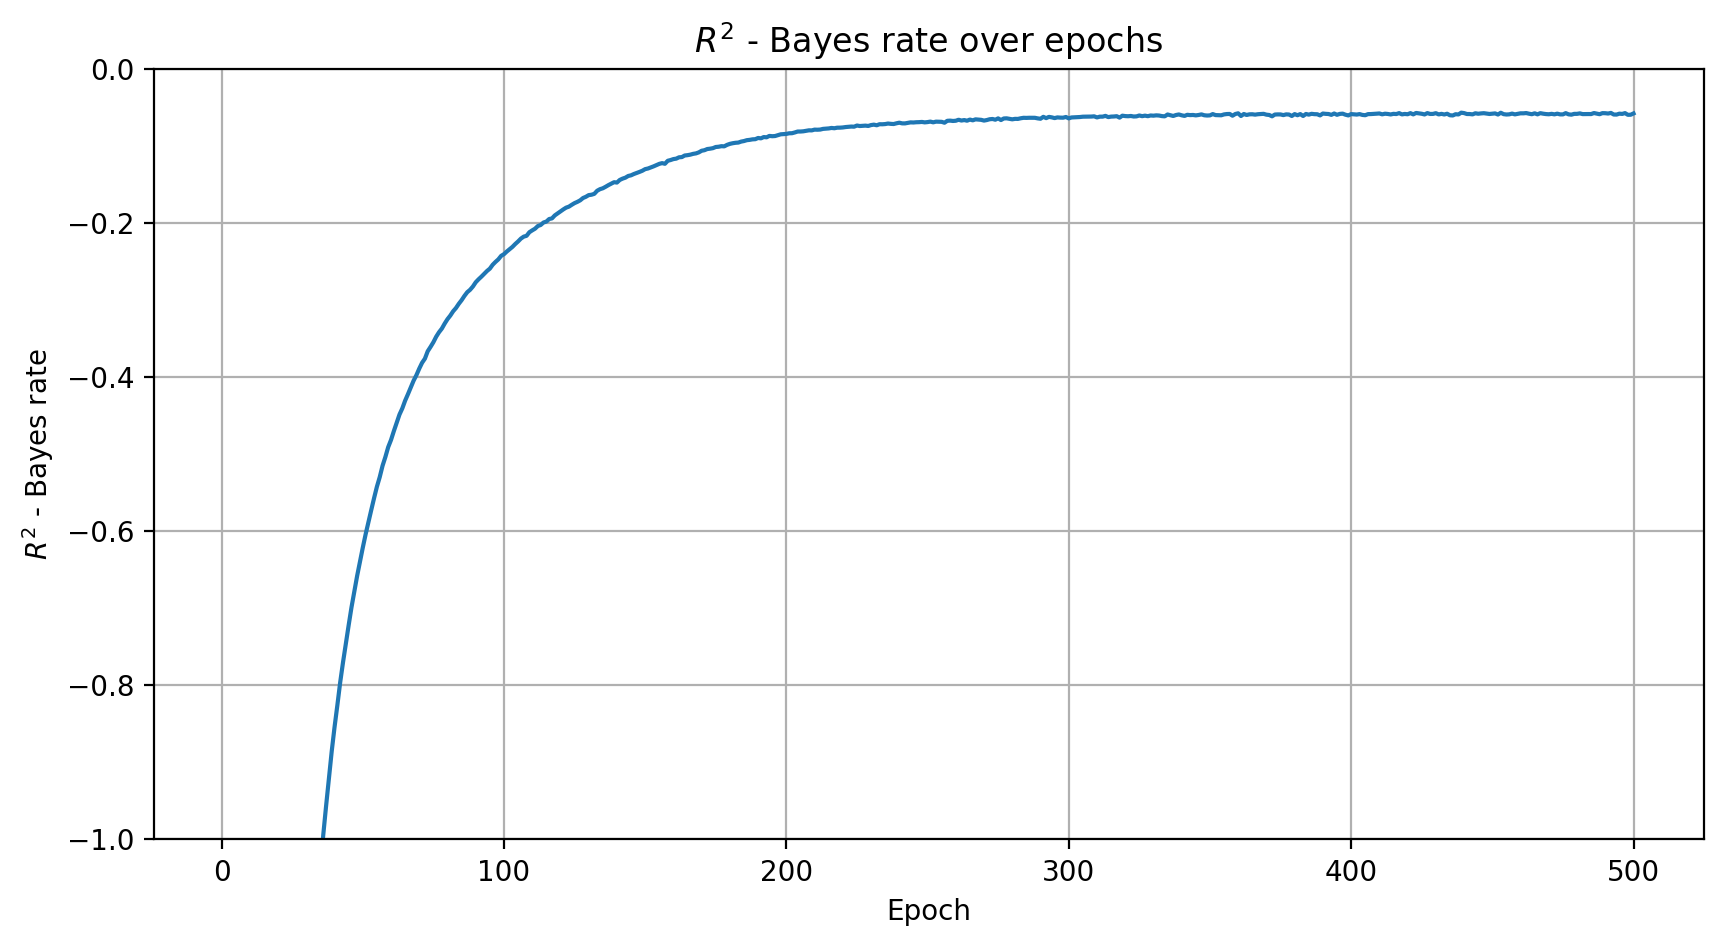

 - train_model() took 2.0105 mins to run
NeuMiss depth-10 on missing rate 0.2:


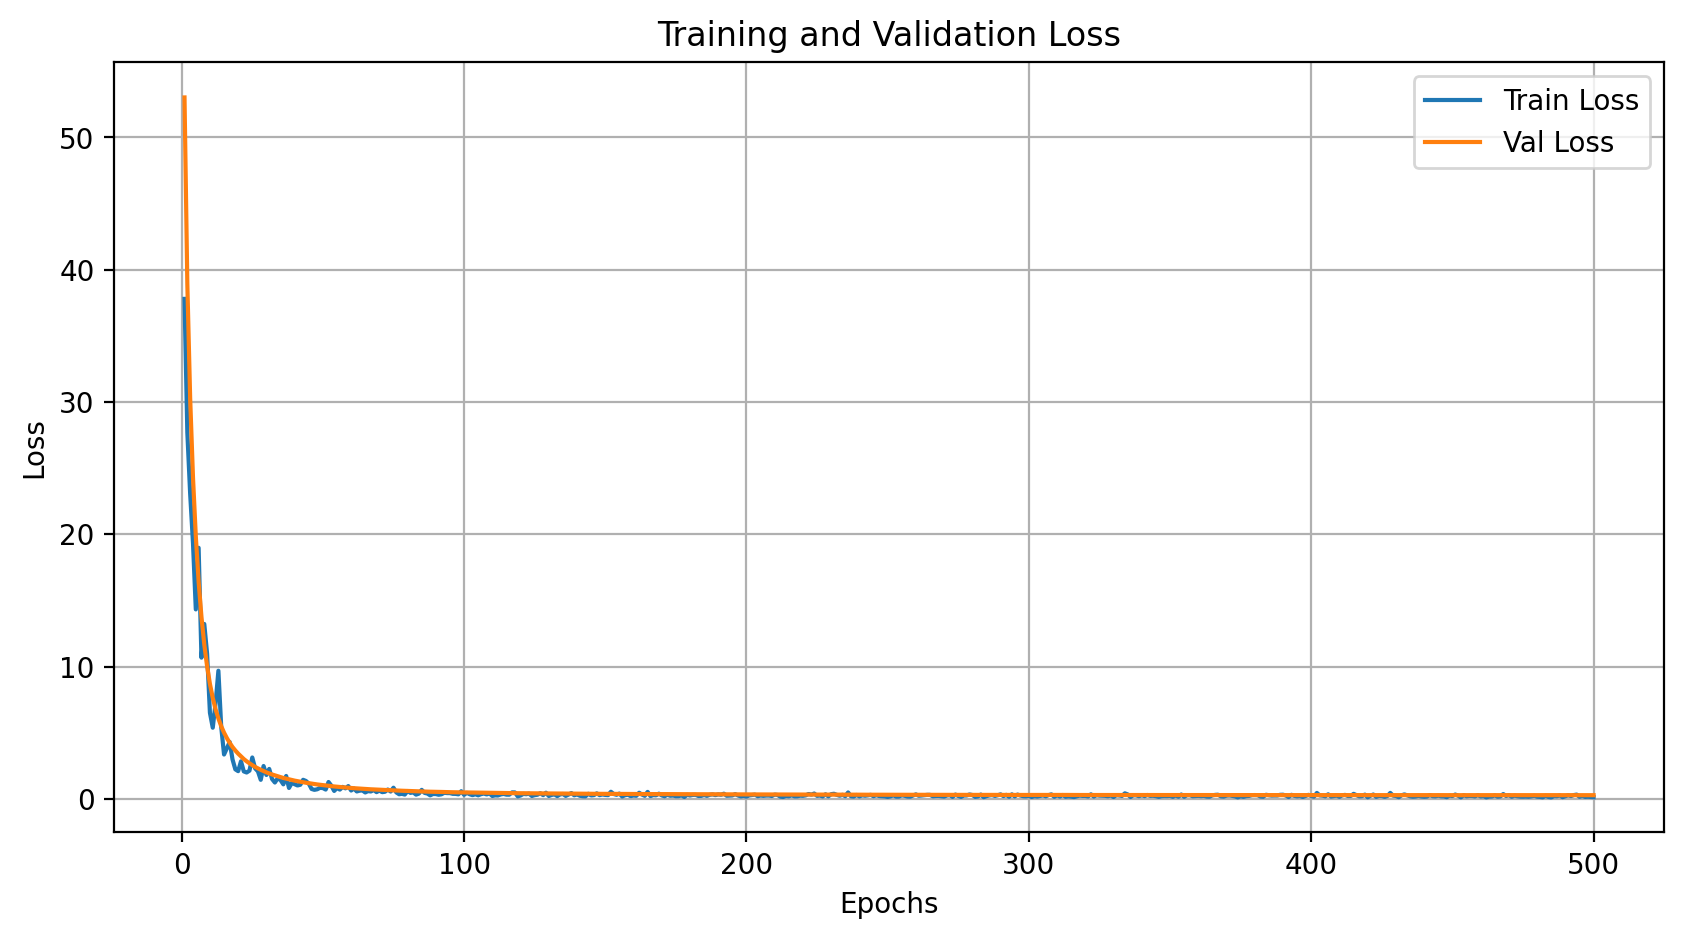

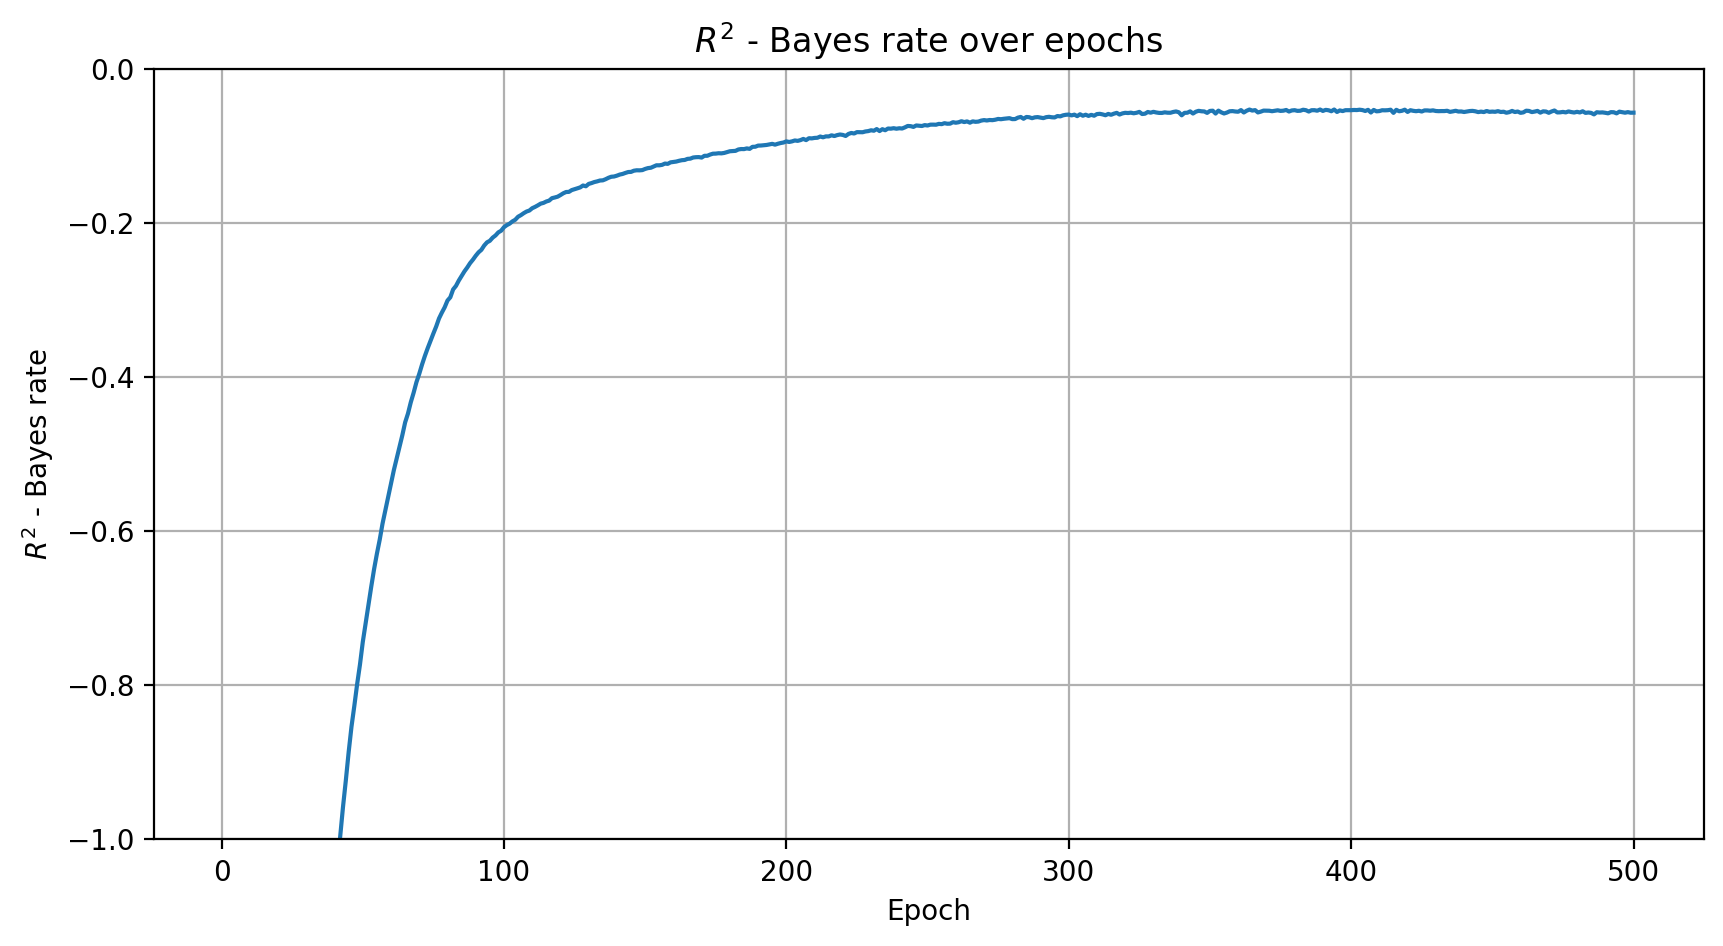

 - train_model() took 2.0065 mins to run
NeuMiss depth-10 on missing rate 0.5:


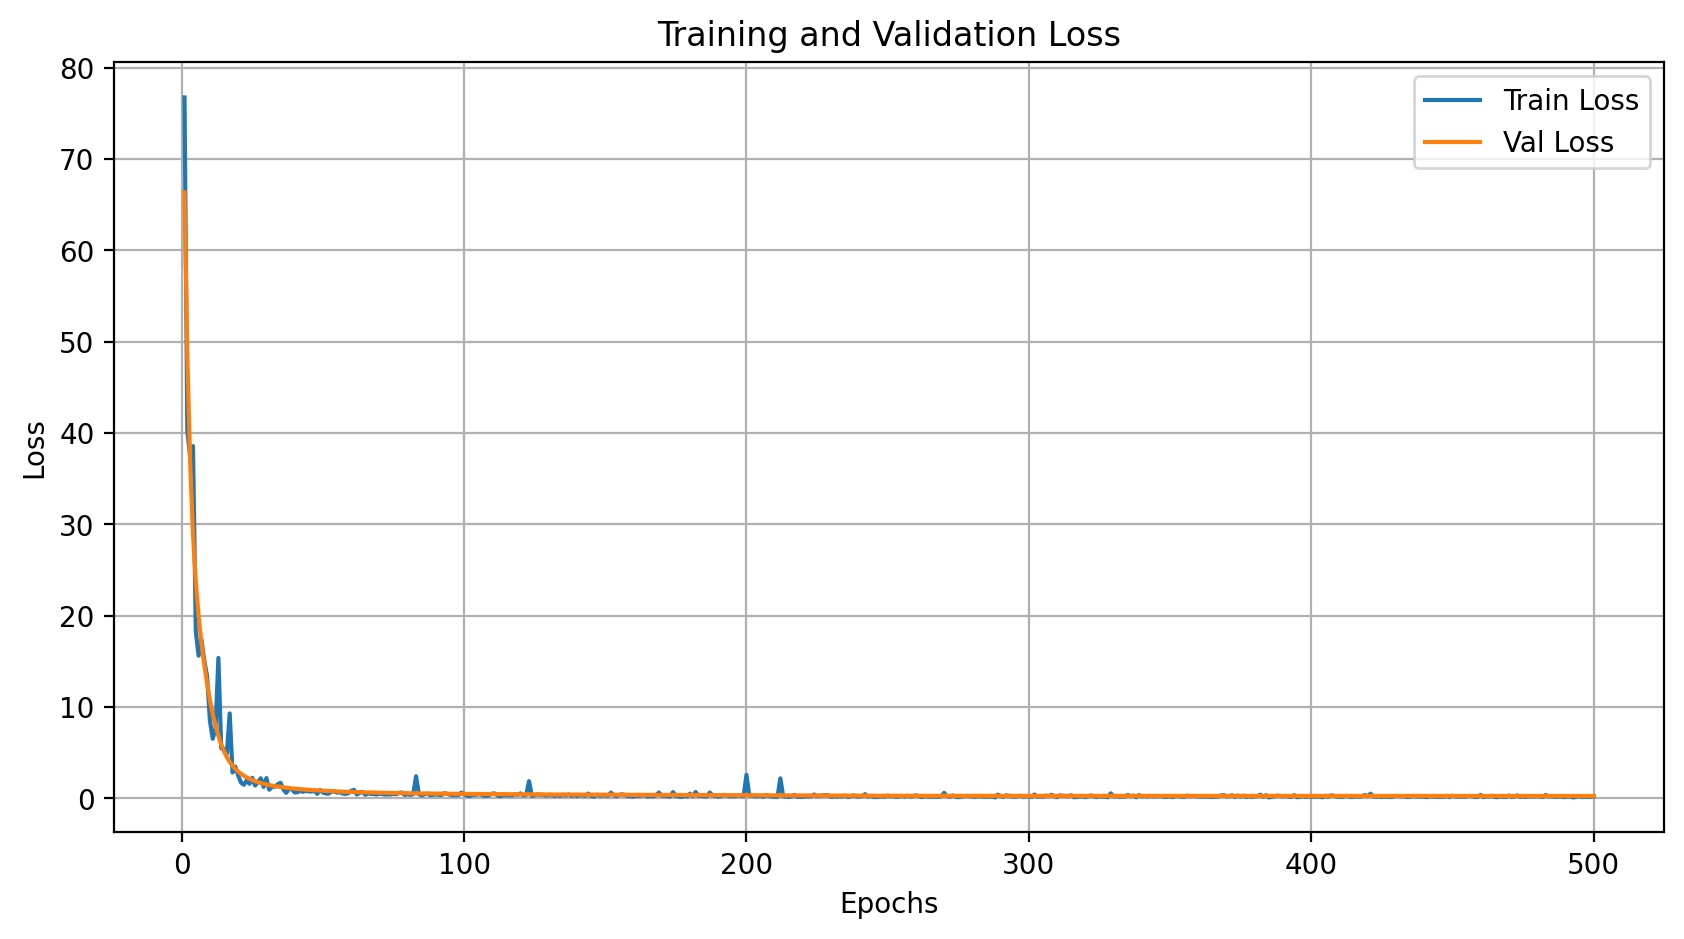

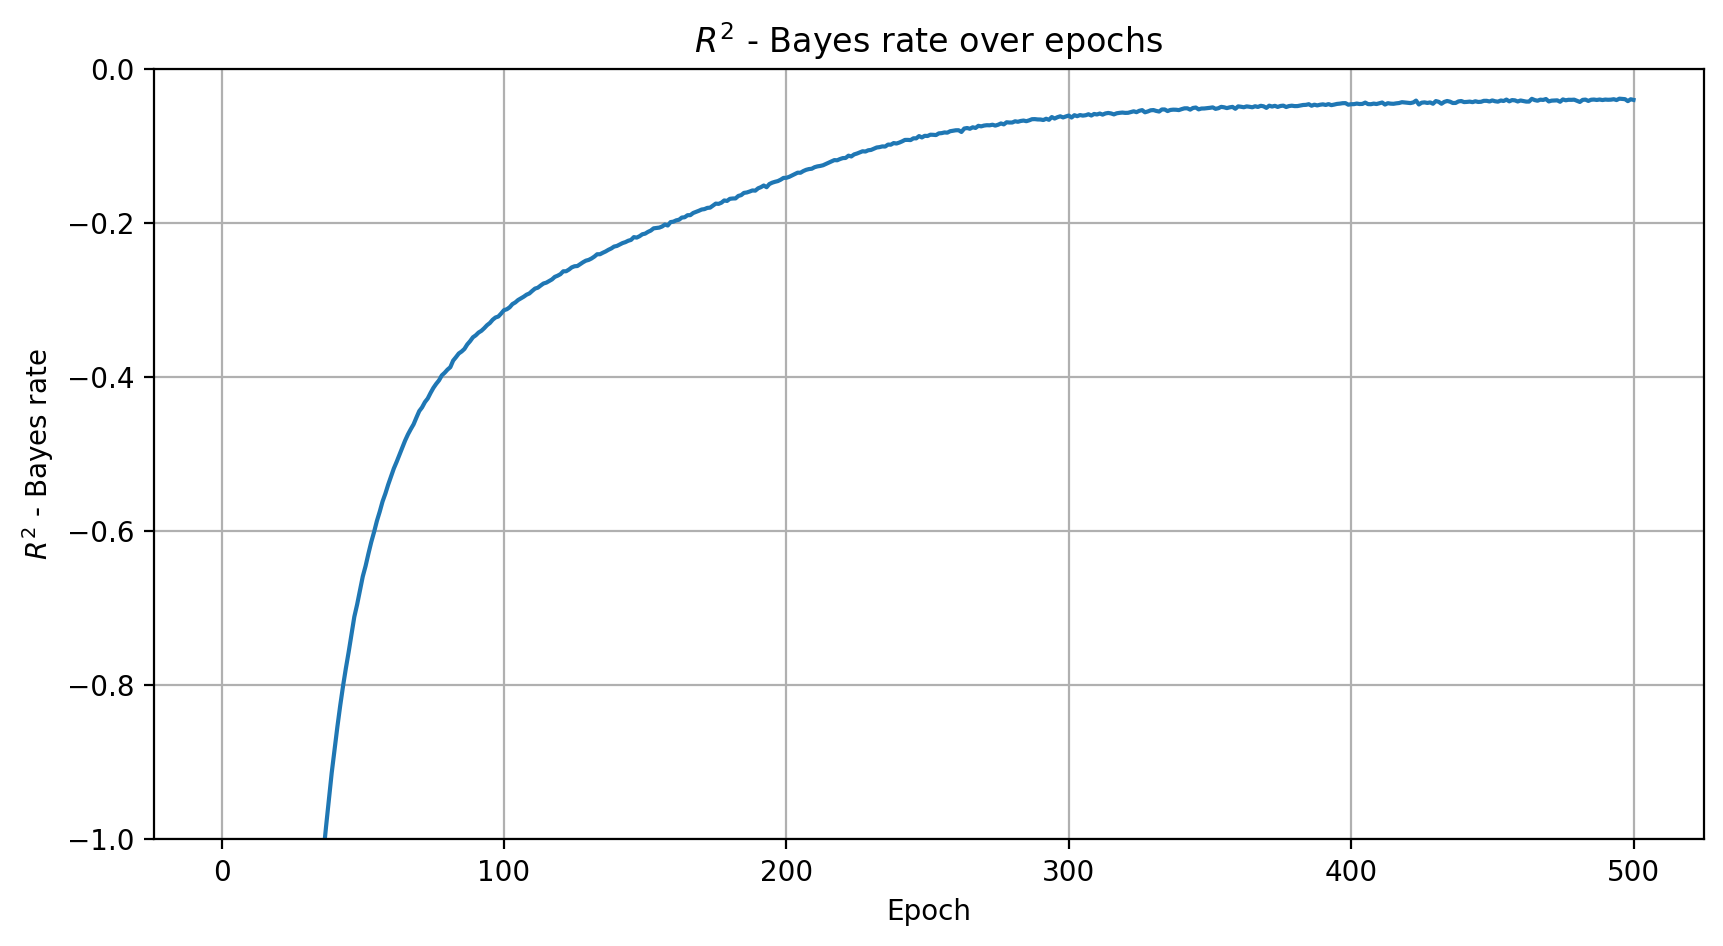

 - train_model() took 1.9941 mins to run
NeuMiss depth-10 on missing rate 0.8:


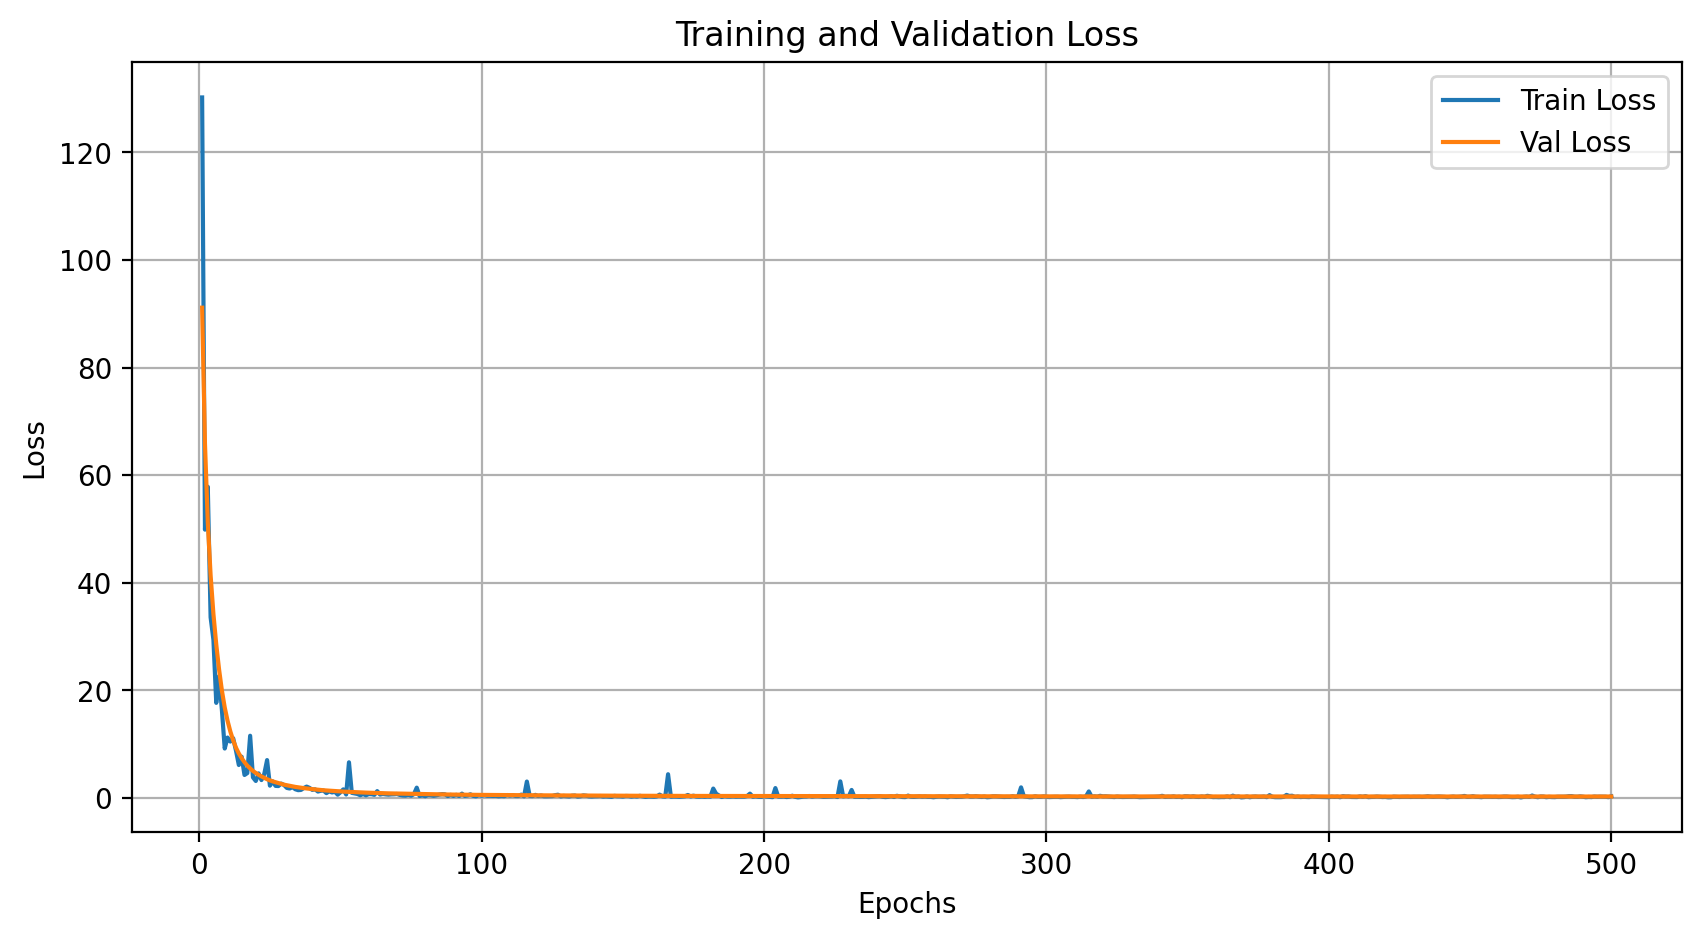

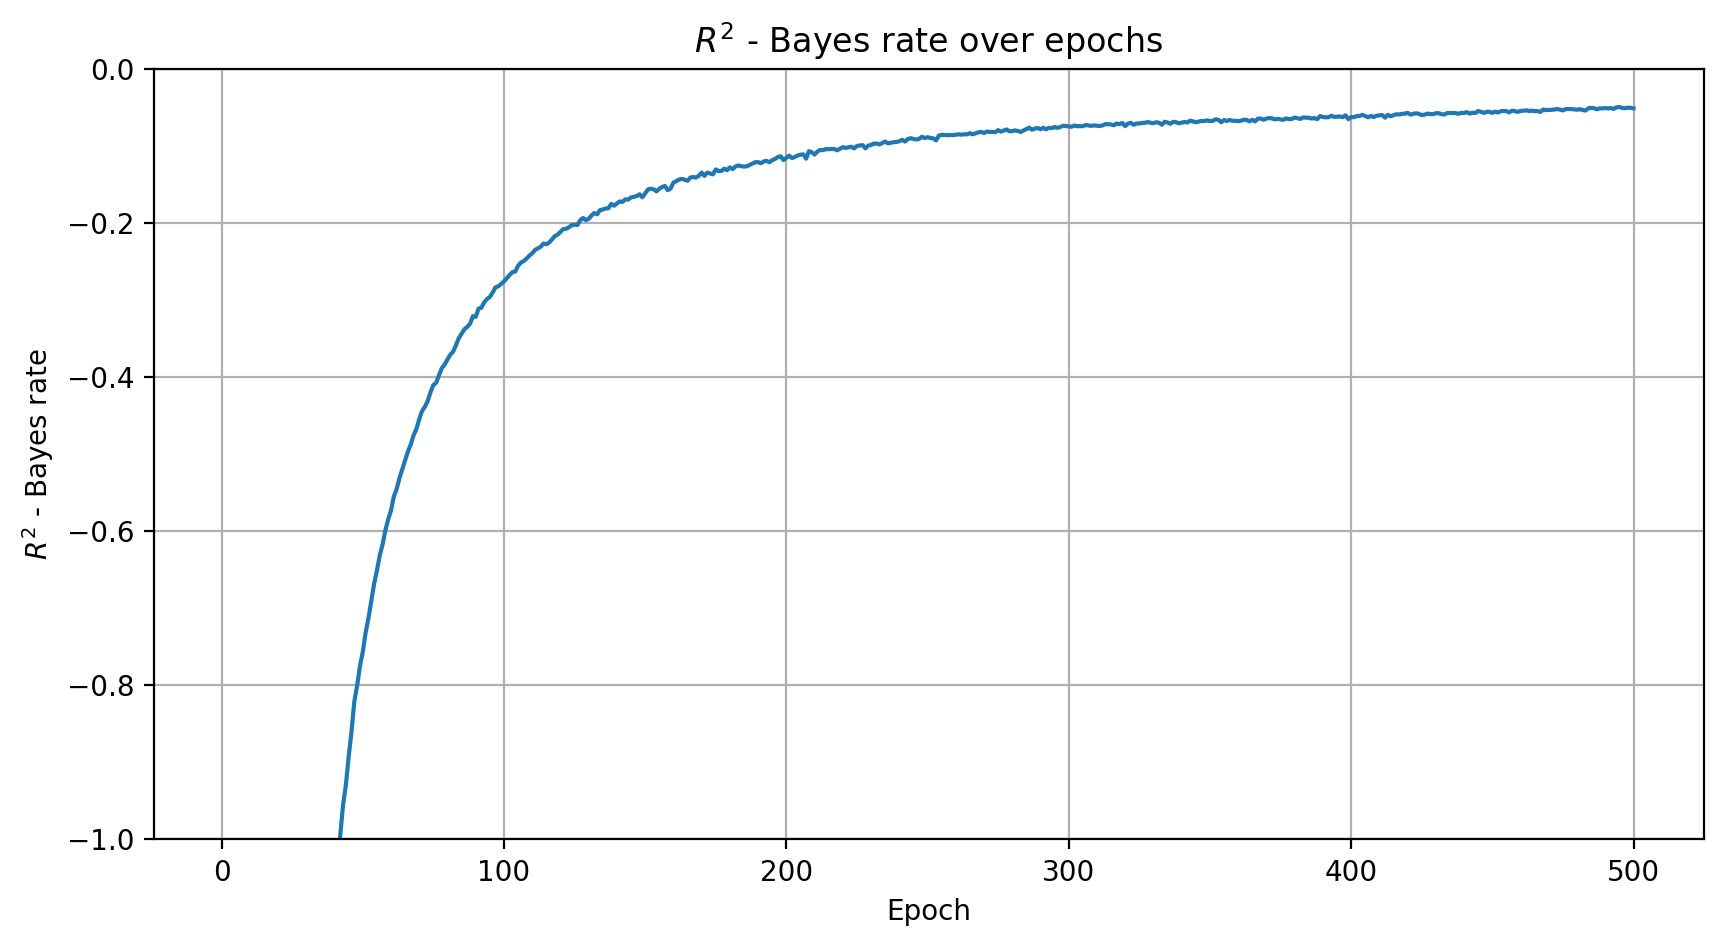

 - train_model() took 2.1060 mins to run


,Name,R2,MSE
0,NeuMiss depth-10 on missing rate 0.1:_train,0.813281,0.201430
1,NeuMiss depth-10 on missing rate 0.1:_val,0.756455,0.271591
2,NeuMiss depth-10 on missing rate 0.1:_test,0.750639,0.275232
3,NeuMiss depth-10 on missing rate 0.2:_train,0.814535,0.200077
4,NeuMiss depth-10 on missing rate 0.2:_val,0.753304,0.275105
5,NeuMiss depth-10 on missing rate 0.2:_test,0.751652,0.274113
6,NeuMiss depth-10 on missing rate 0.5:_train,0.819078,0.195176
7,NeuMiss depth-10 on missing rate 0.5:_val,0.769972,0.256518
8,NeuMiss depth-10 on missing rate 0.5:_test,0.768238,0.255806
9,NeuMiss depth-10 on missing rate 0.8:_train,0.797284,0.218687


In [ ]:
result = pd.DataFrame()

for rate in [0.1, 0.2, 0.5, 0.8]:
    ds_train, ds_val, ds_test = generate_dataset(n=n, d=d, missing_rate=rate, verbose=0)
    train_loader = DataLoader(ds_train, batch_size, shuffle=True)
    val_loader = DataLoader(ds_val, batch_size)
    test_loader = DataLoader(ds_test, batch_size)

    name = f'NeuMiss depth-10 on missing rate {rate}:'
    print(name)
    model = NeuMiss(n_features=d, depth=10, residual_connection=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_model(model, criterion, train_loader, val_loader, test_loader,
                optimizer, n_epochs=500, verbose=False)
    new_result = create_results_df(model, val_loader, test_loader, name=name)
    result = pd.concat([result, new_result], ignore_index=True, sort=False)

result

### Different number of samples, features

In [ ]:
ns = [100, 1000, 5000, 10000]
ds = [10, 20]
result = pd.DataFrame()

for n in ns:
    for d in ds:
        ds_train, ds_val, ds_test = generate_dataset(n=n, d=d, missing_rate=0.5, verbose=0)
        train_loader = DataLoader(ds_train, batch_size, shuffle=True)
        val_loader = DataLoader(ds_val, batch_size)
        test_loader = DataLoader(ds_test, batch_size)

        name = f'NeuMiss depth-10 on {n} samples, {d} features:'
        print(name)
        model = NeuMiss(n_features=d, depth=10, residual_connection=True)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        train_model(model, criterion, train_loader, val_loader, test_loader,
                    optimizer, n_epochs=500, verbose=False, hide_plot=True)
        new_result = create_results_df(model, val_loader, test_loader, name=name)
        result = pd.concat([result, new_result], ignore_index=True, sort=False)

result

NeuMiss depth-10 on 100 samples, 10 features:
 - train_model() took 0.0986 mins to run
NeuMiss depth-10 on 100 samples, 20 features:
 - train_model() took 0.0653 mins to run
NeuMiss depth-10 on 1000 samples, 10 features:
 - train_model() took 0.2459 mins to run
NeuMiss depth-10 on 1000 samples, 20 features:
 - train_model() took 0.2560 mins to run
NeuMiss depth-10 on 5000 samples, 10 features:
 - train_model() took 1.0559 mins to run
NeuMiss depth-10 on 5000 samples, 20 features:
 - train_model() took 1.1245 mins to run
NeuMiss depth-10 on 10000 samples, 10 features:
 - train_model() took 2.0533 mins to run
NeuMiss depth-10 on 10000 samples, 20 features:
 - train_model() took 2.1544 mins to run
NeuMiss depth-10 on 50000 samples, 10 features:
 - train_model() took 9.9675 mins to run
NeuMiss depth-10 on 50000 samples, 20 features:
 - train_model() took 10.422 mins to run


,Name,R2,MSE
0,"NeuMiss depth-10 on 100 samples, 10 features:_...",0.860850,0.158074
1,"NeuMiss depth-10 on 100 samples, 10 features:_val",-1.630658,2.041580
2,"NeuMiss depth-10 on 100 samples, 10 features:_...",-12.713304,7.188409
3,"NeuMiss depth-10 on 100 samples, 20 features:_...",0.945021,0.059629
4,"NeuMiss depth-10 on 100 samples, 20 features:_val",-324.832336,205.509857
5,"NeuMiss depth-10 on 100 samples, 20 features:_...",-418.380066,224.806305
6,"NeuMiss depth-10 on 1000 samples, 10 features:...",0.597567,0.453856
7,"NeuMiss depth-10 on 1000 samples, 10 features:...",-1.584210,2.805610
8,"NeuMiss depth-10 on 1000 samples, 10 features:...",-0.490830,1.640335
9,"NeuMiss depth-10 on 1000 samples, 20 features:...",0.727867,0.295264


# Real-world datasets

In [ ]:
# To be continue...